In [ ]:
import jax
import jax.numpy as jnp
from jcm.model import Model, get_coords
from jcm.boundaries import boundaries_from_file
import matplotlib.pyplot as plt


jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

orography = jnp.load('../jcm/data/bc/t30/clim/orography.npy')
default_boundaries = boundaries_from_file('../jcm/data/bc/t30/clim/boundaries_daily.nc')

def model_run_wrapper_mean(tsea):
    boundary_data = default_boundaries.copy(tsea=tsea)
    model = Model(orography=orography)
    predictions = model.run(save_interval=6/24., total_time=2., boundaries=boundary_data)
    return (predictions.physics.shortwave_rad.qcloud.mean(axis=1) * model.geometry.coa[None]).mean(axis=1)

def model_run_wrapper(tsea):
    boundary_data = default_boundaries.copy(tsea=tsea)
    model = Model(orography=orography)
    return model.run(save_interval=6/24., total_time=2., boundaries=boundary_data)

# jacrev

In [2]:
%load_ext memory_profiler

In [3]:
%%memit
jac = jax.jacrev(model_run_wrapper_mean)(default_boundaries().tsea)

/home/jvm/miniconda3/envs/jax-dev-cuda/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jvm/miniconda3/envs/jax-dev-cuda/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


peak memory: 3625.16 MiB, increment: 1154.28 MiB


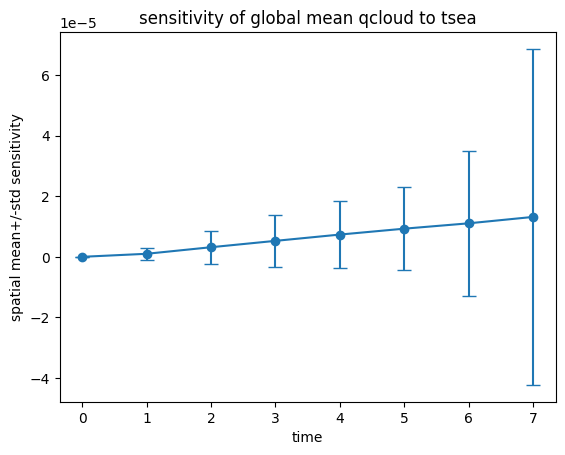

In [ ]:
# Create a line plot with error bars
plt.errorbar(range(jac.shape[0]), jnp.mean(jac, axis=(1, 2)), yerr=jnp.std(jac, axis=(1,2)), fmt='-o', capsize=5)
plt.xlabel('time')
plt.ylabel('spatial mean+/-std sensitivity')
plt.title('sensitivity of global mean qcloud to tsea')
plt.show()

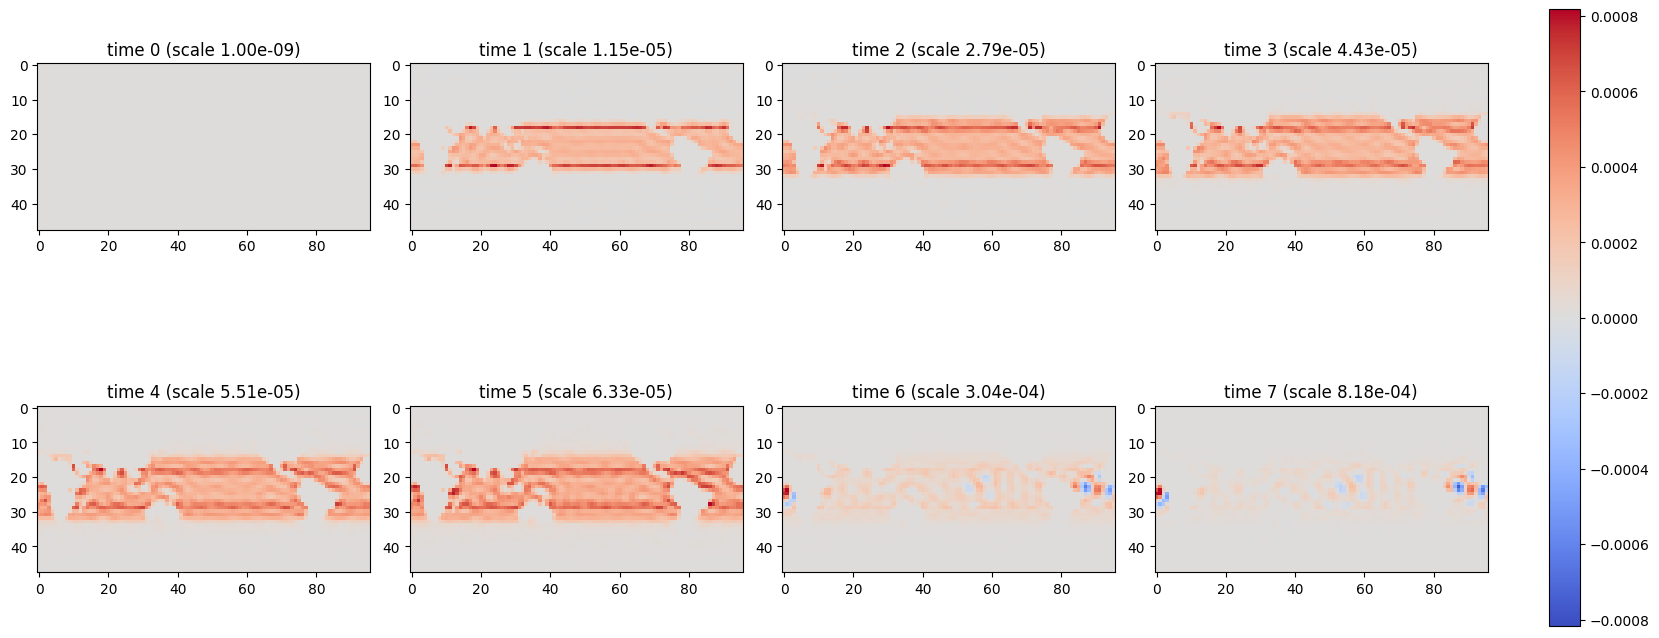

In [ ]:
vabs = jnp.maximum(1e-9, jnp.max(jnp.abs(jac), axis=(1,2)))
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    im = axs[i//4, i%4].imshow(jac[i].T[::-1], vmin=-vabs[i], vmax=vabs[i], cmap='coolwarm')
    axs[i//4, i%4].set_title(f'time {i} (scale {vabs[i]:.2e})')
plt.tight_layout()
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

# jvp

In [6]:
tsea = default_boundaries().tsea

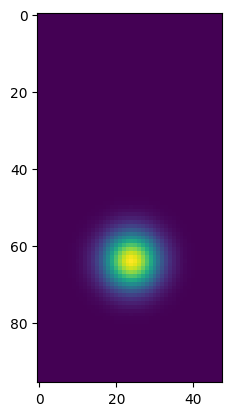

In [ ]:
def localized_gaussian(m, n, i, j, sigma_i, sigma_j):
    """
    Generate a 2D Gaussian on an m x n grid centered at (i, j) with standard deviations sigma_i and sigma_j.
    """
    x = jnp.arange(n)
    y = jnp.arange(m)
    X, Y = jnp.meshgrid(x, y)
    
    gaussian = jnp.exp(-(((X - i) ** 2) / (2 * sigma_i ** 2) + ((Y - j) ** 2) / (2 * sigma_j ** 2)))
    return gaussian

# Example usage
m, n = tsea.shape
i, j = 2 * n // 4, 2 * m // 3    # Center of the Gaussian
sigma_i, sigma_j = 5, 5  # Standard deviations
g = localized_gaussian(m, n, i, j, sigma_i, sigma_j)

plt.imshow(g)

tangent = g

In [8]:
y, jvp_at_x = jax.jvp(model_run_wrapper, (tsea,), (tangent,))

In [9]:
grad_ds = create_model().predictions_to_xarray(jvp_at_x)
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 31.6MB


In [10]:
print(list(grad_ds.variables))

['shortwave_rad.ozupp', 'surface_flux.evap.0', 'surface_flux.vstr.0', 'shortwave_rad.cloudc', 'mod_radcon.albsfc', 'shortwave_rad.qcloud', 'surface_flux.rlns', 'mod_radcon.flux.0', 'longwave_rad.ftop', 'surface_flux.evap.2', 'surface_flux.shf.2', 'convection.cbmf', 'condensation.dqlsc', 'surface_flux.hfluxn.0', 'shortwave_rad.stratz', 'u_dot_grad_log_sp', 'condensation.precls', 'convection.iptop', 'mod_radcon.st4a.0', 'shortwave_rad.dfabs', 'surface_flux.ustr.0', 'mod_radcon.alb_s', 'mod_radcon.stratc.1', 'surface_flux.ustr.2', 'mod_radcon.tau2.3', 'mod_radcon.stratc.0', 'temperature', 'shortwave_rad.zenit', 'convection.psa', 'surface_flux.rlus.1', 'vorticity', 'humidity.qsat', 'mod_radcon.flux.2', 'surface_flux.evap.1', 'surface_flux.rlus.0', 'land_model.stl_am', 'shortwave_rad.ftop', 'humidity.rh', 'surface_flux.rlus.2', 'surface_flux.tskin', 'shortwave_rad.fsol', 'mod_radcon.tau2.1', 'date.tyear', 'shortwave_rad.rsds', 'surface_flux.hfluxn.1', 'surface_flux.vstr.1', 'surface_flux.sh

gradient of shortwave_rad.ozupp is 0.0
gradient of shortwave_rad.cloudc is 0.0
gradient of mod_radcon.albsfc is 0.0
gradient of convection.cbmf is 0.0
gradient of condensation.dqlsc is 0.0
gradient of shortwave_rad.stratz is 0.0
gradient of condensation.precls is 0.0
gradient of mod_radcon.alb_s is 0.0
gradient of mod_radcon.tau2.3 is -0.0
gradient of shortwave_rad.zenit is 0.0


/home/jvm/miniconda3/envs/jax-dev-cuda/lib/python3.11/site-packages/xarray/plot/facetgrid.py:219: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


gradient of land_model.stl_am is 0.0
gradient of shortwave_rad.fsol is 0.0
gradient of condensation.dtlsc is 0.0
gradient of shortwave_rad.ozone is 0.0
gradient of mod_radcon.alb_l is 0.0
gradient of mod_radcon.snowc is 0.0
gradient of mod_radcon.st4a.1 is 0.0
gradient of convection.precnv is 0.0
gradient of land_model.stl_lm is 0.0
gradient of mod_radcon.tau2.2 is -0.0


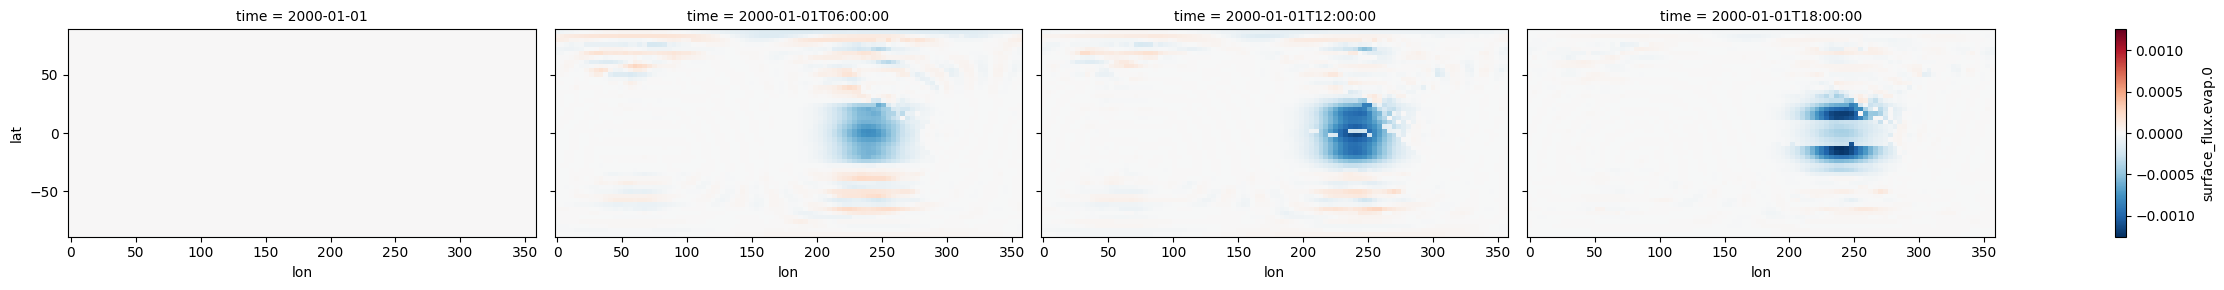

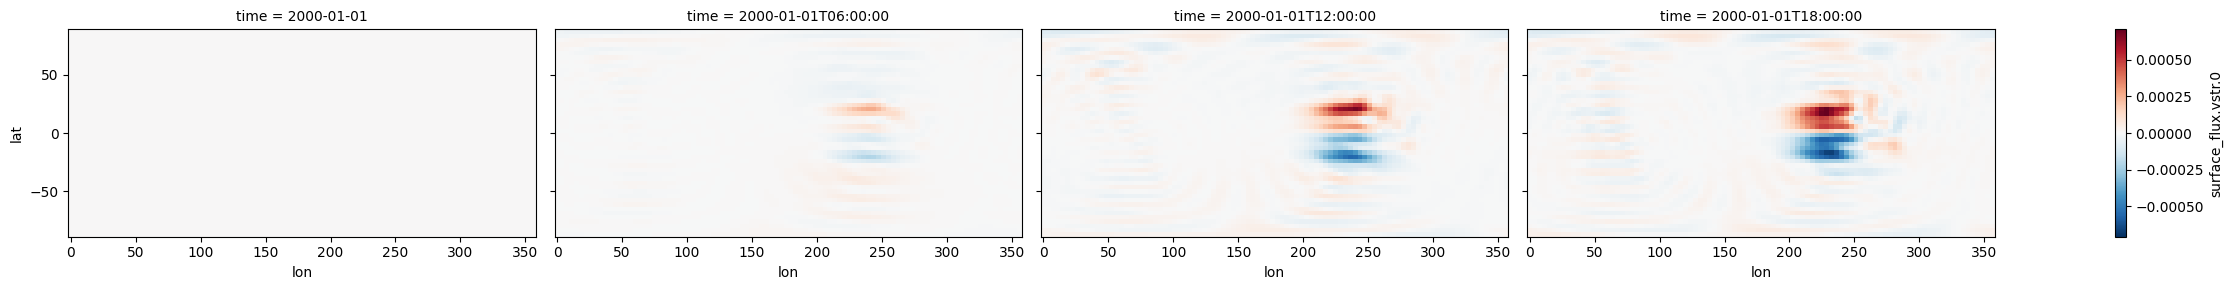

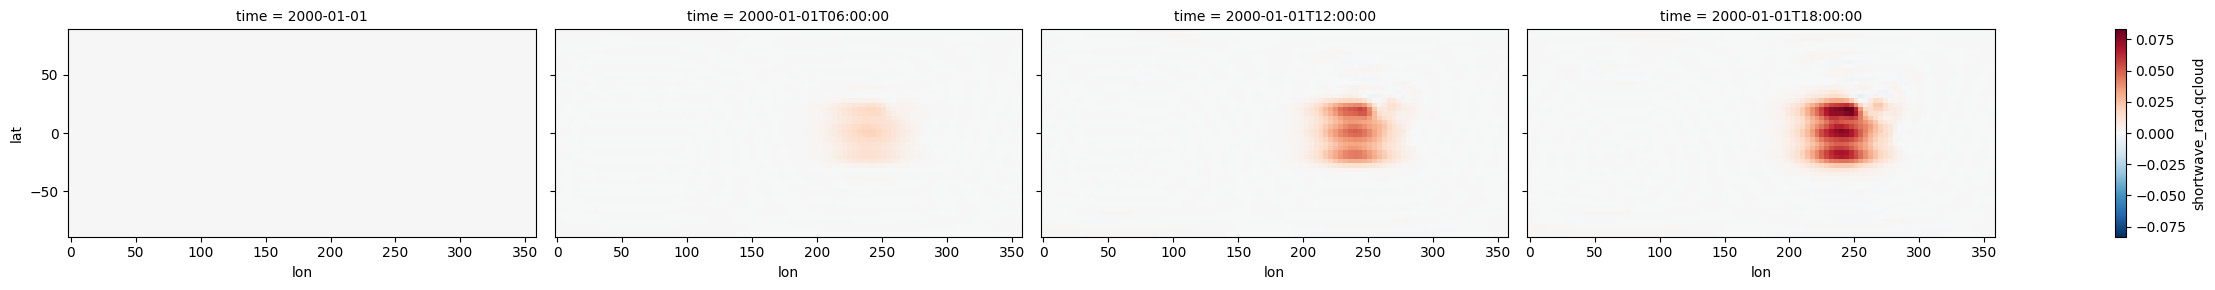

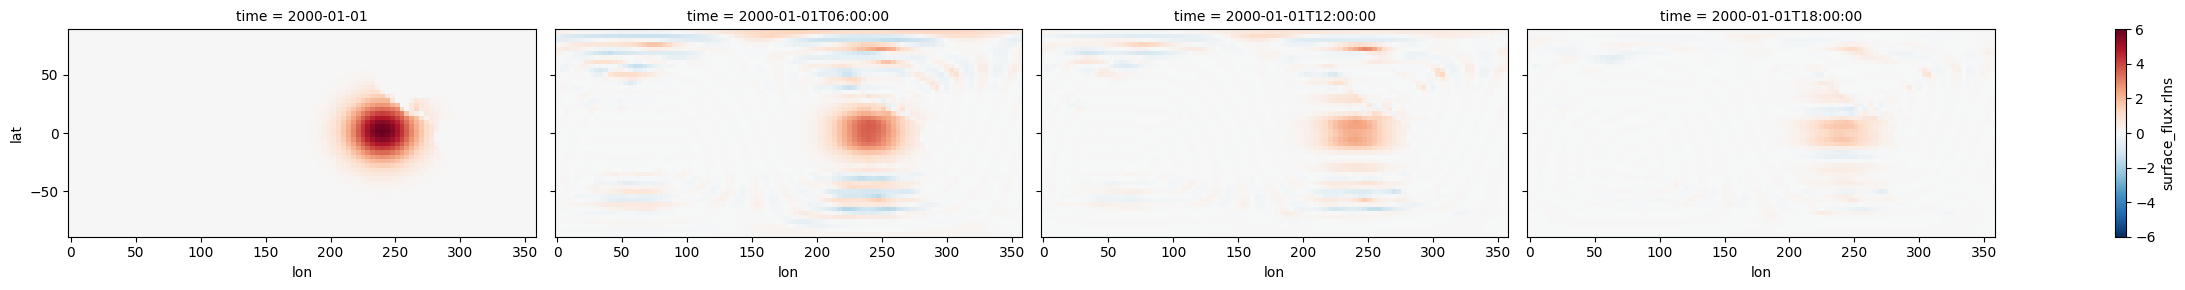

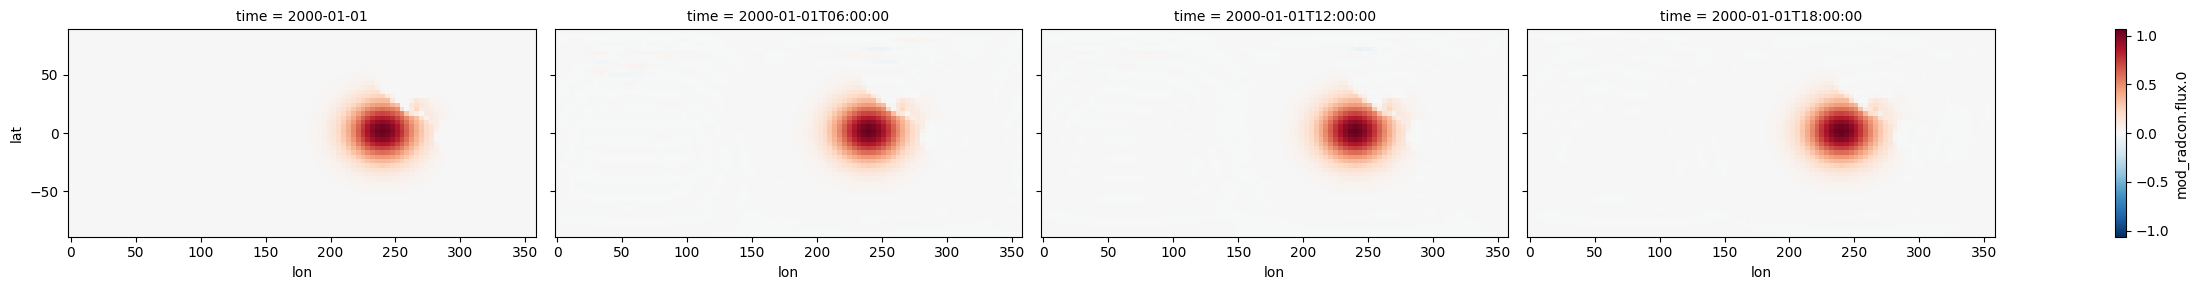

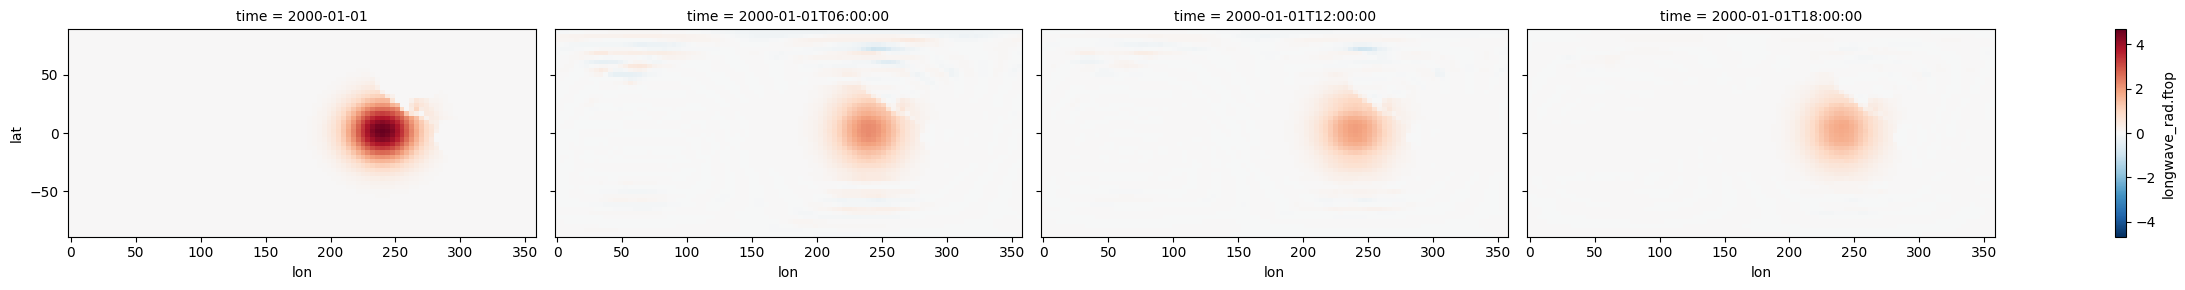

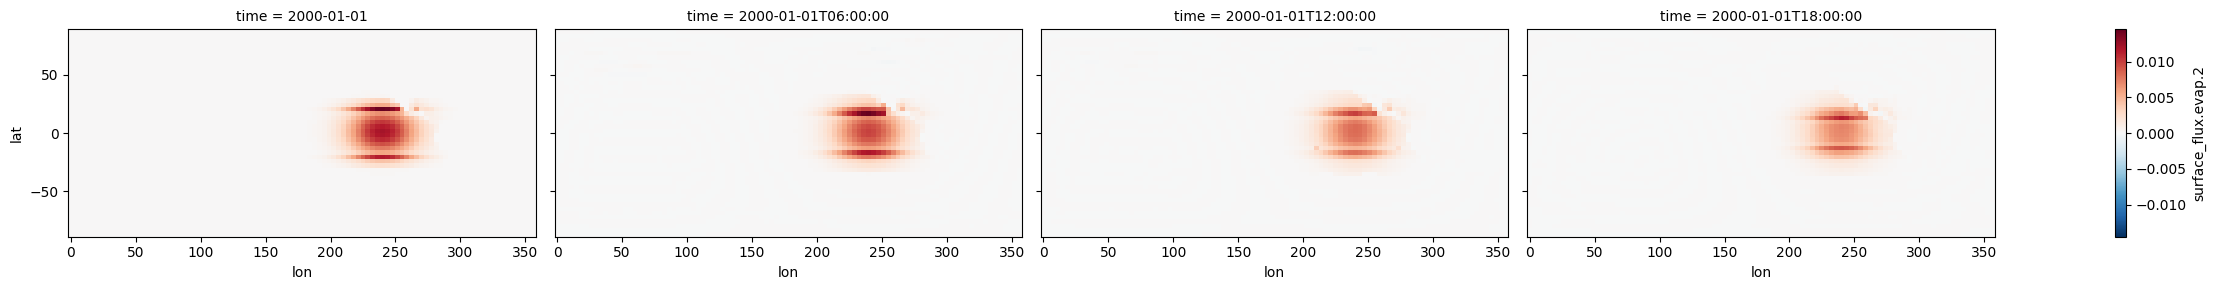

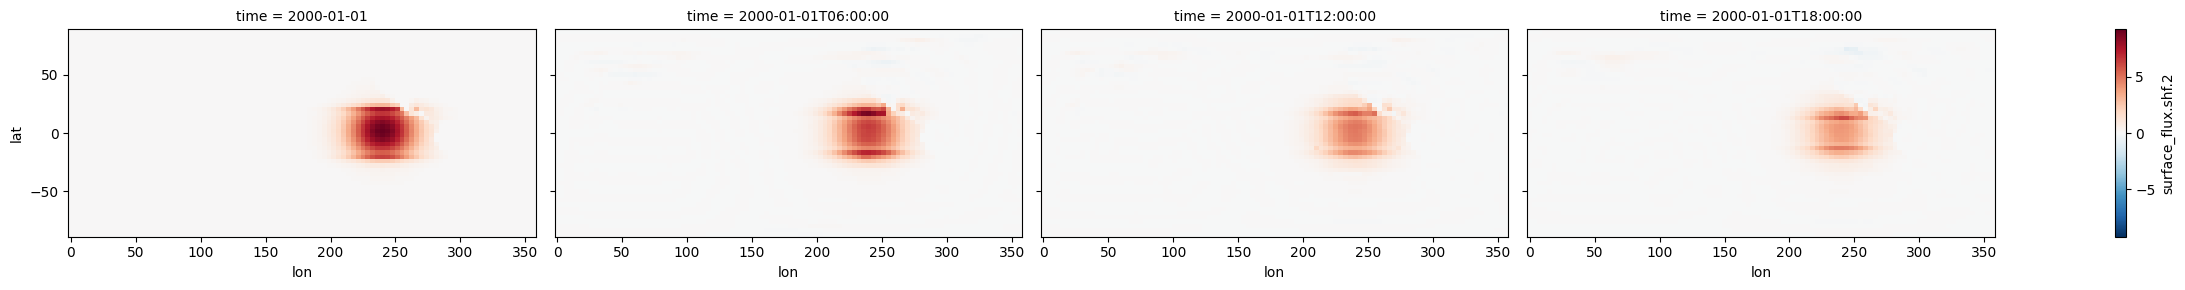

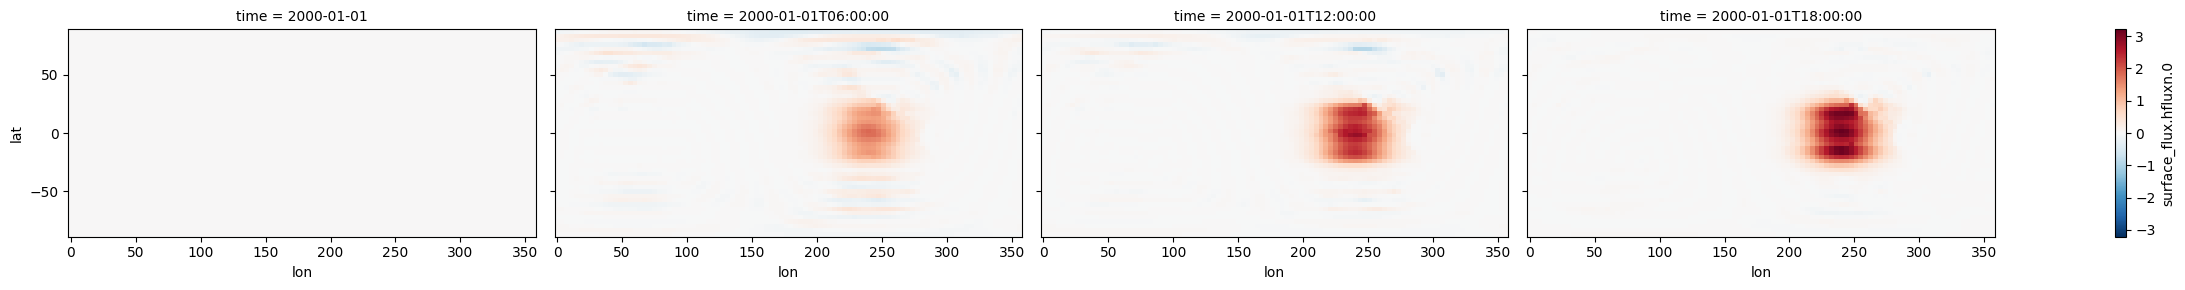

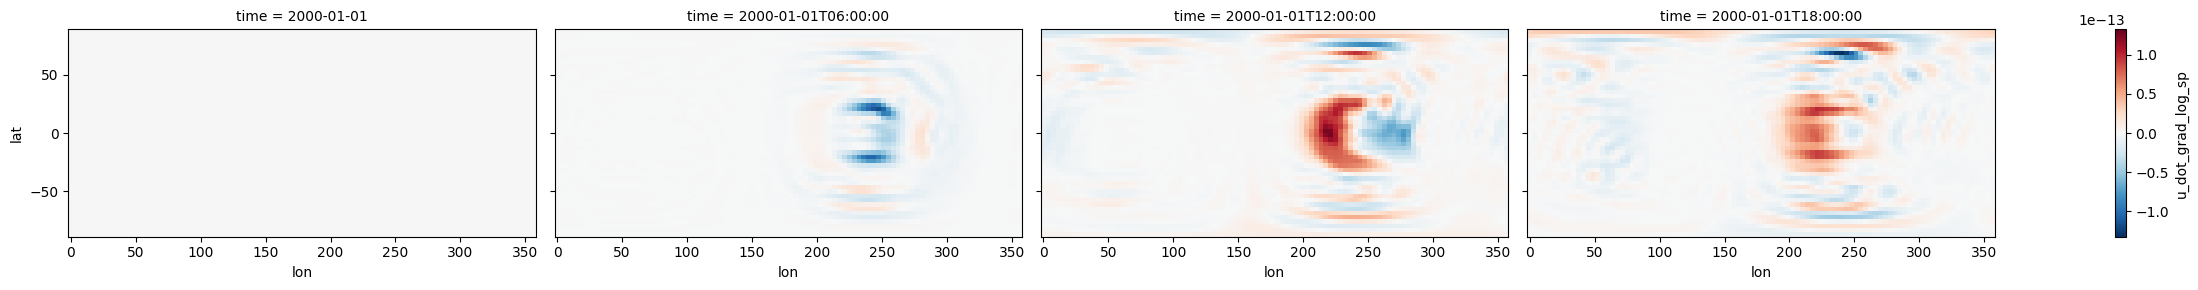

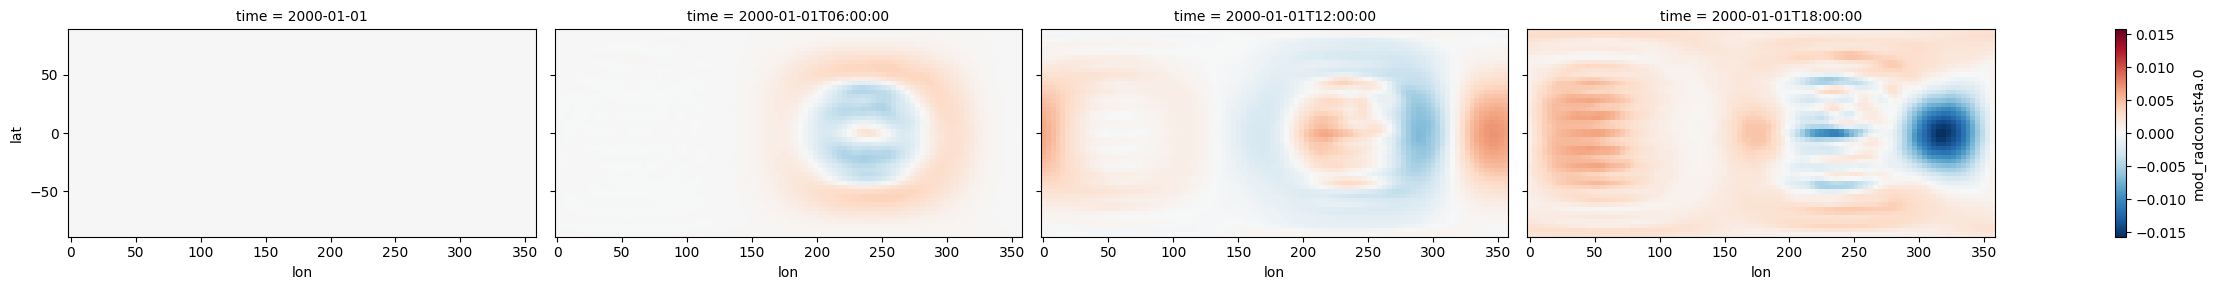

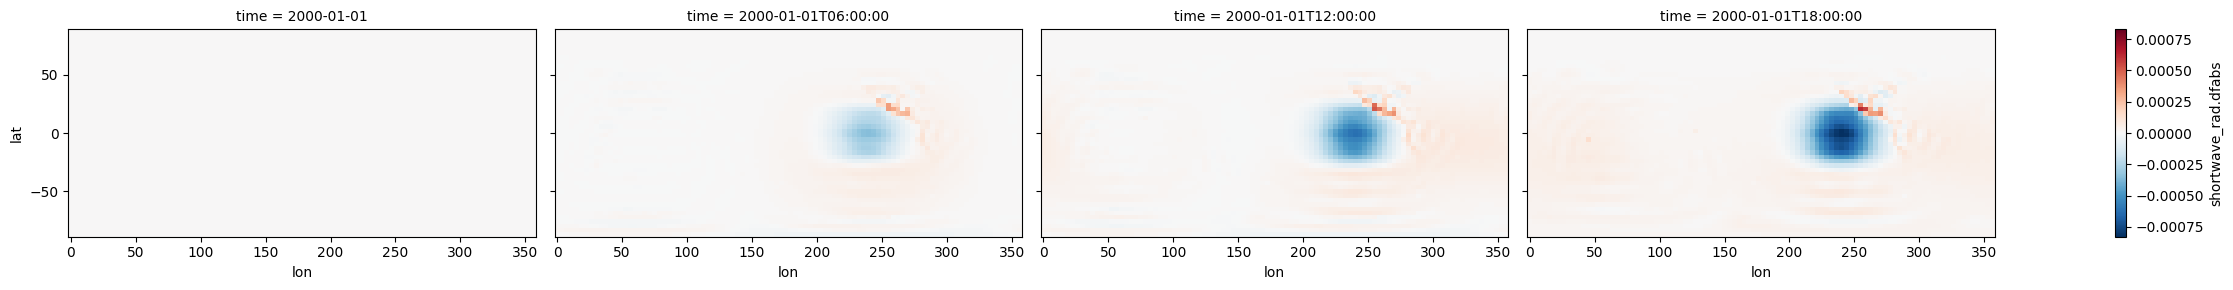

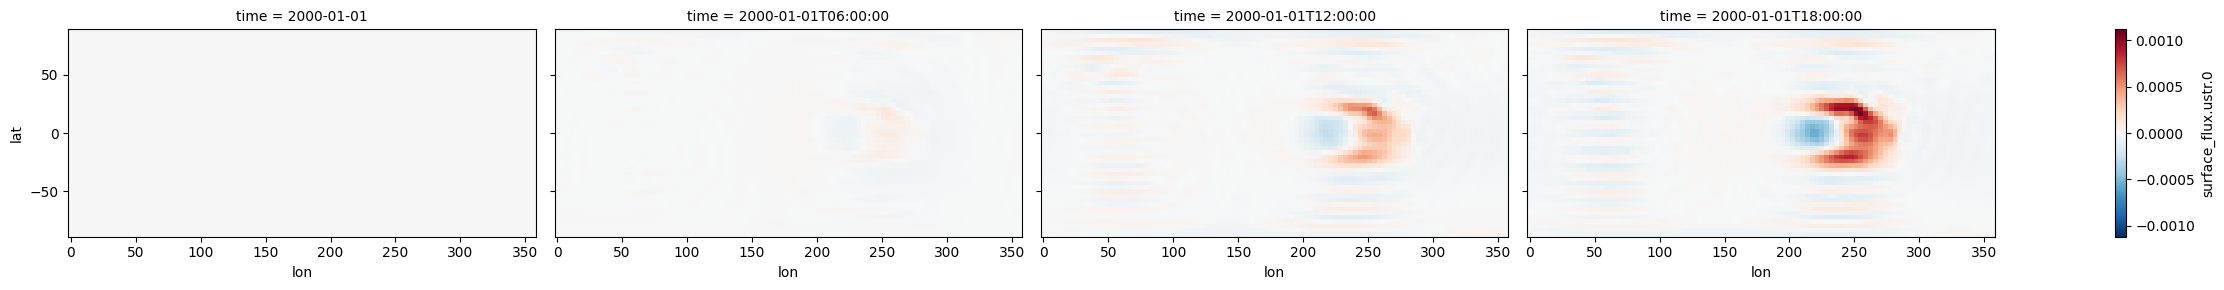

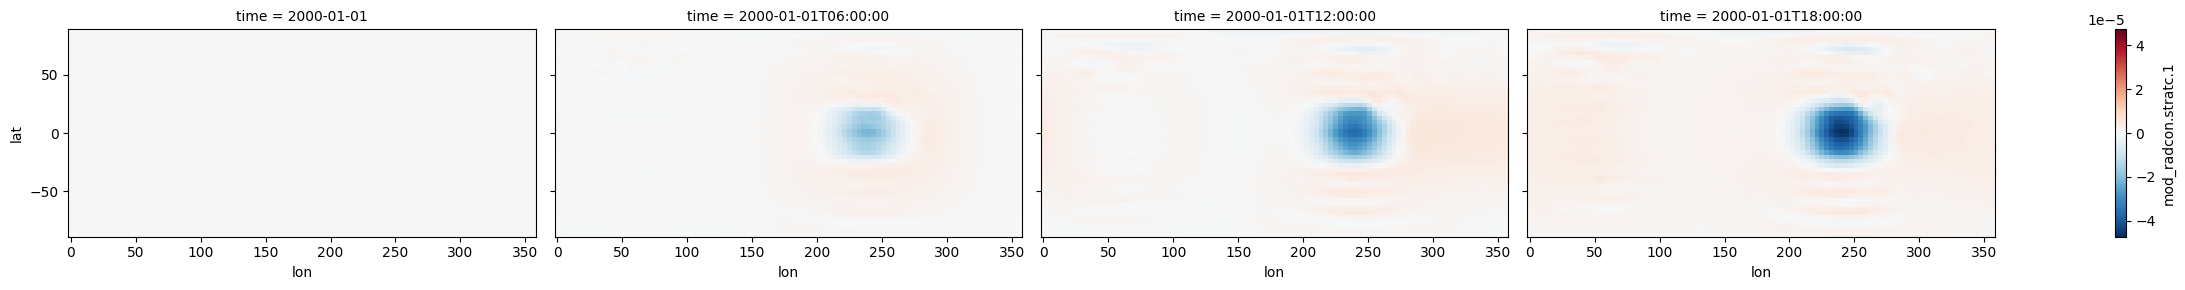

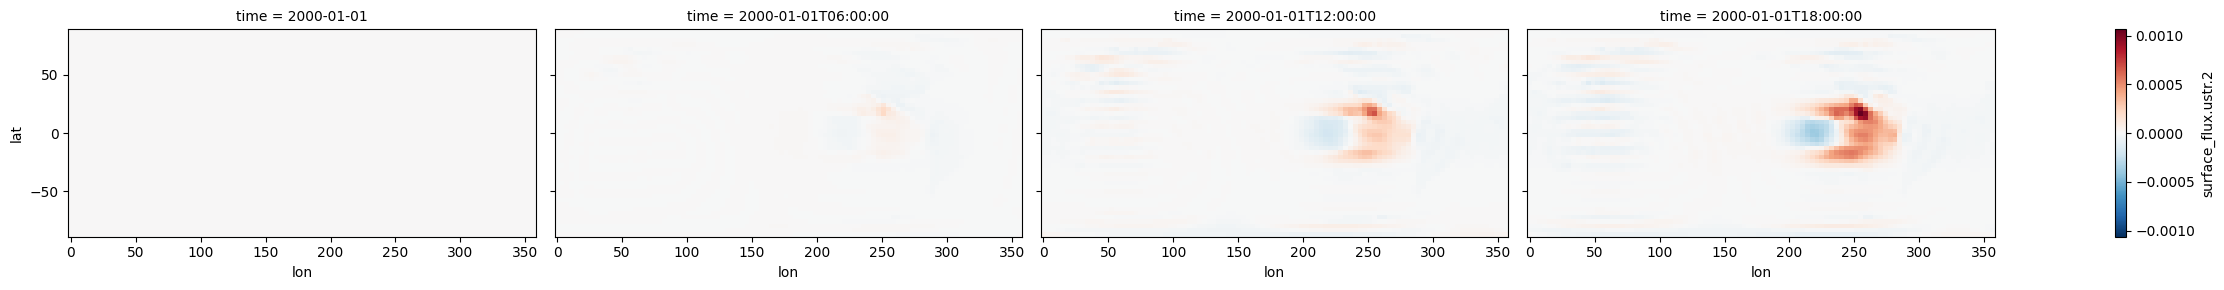

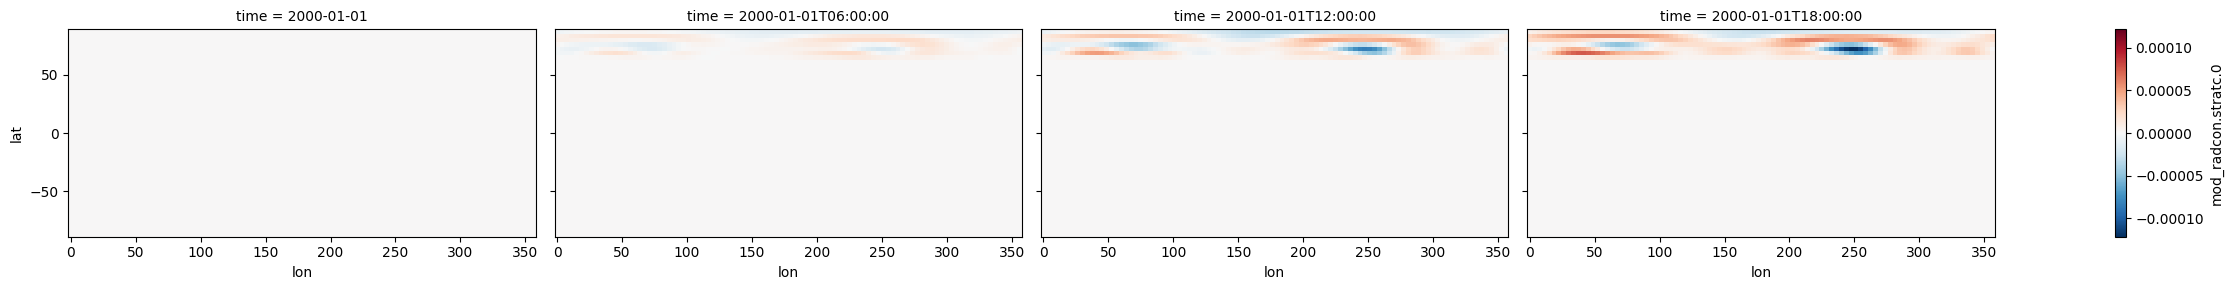

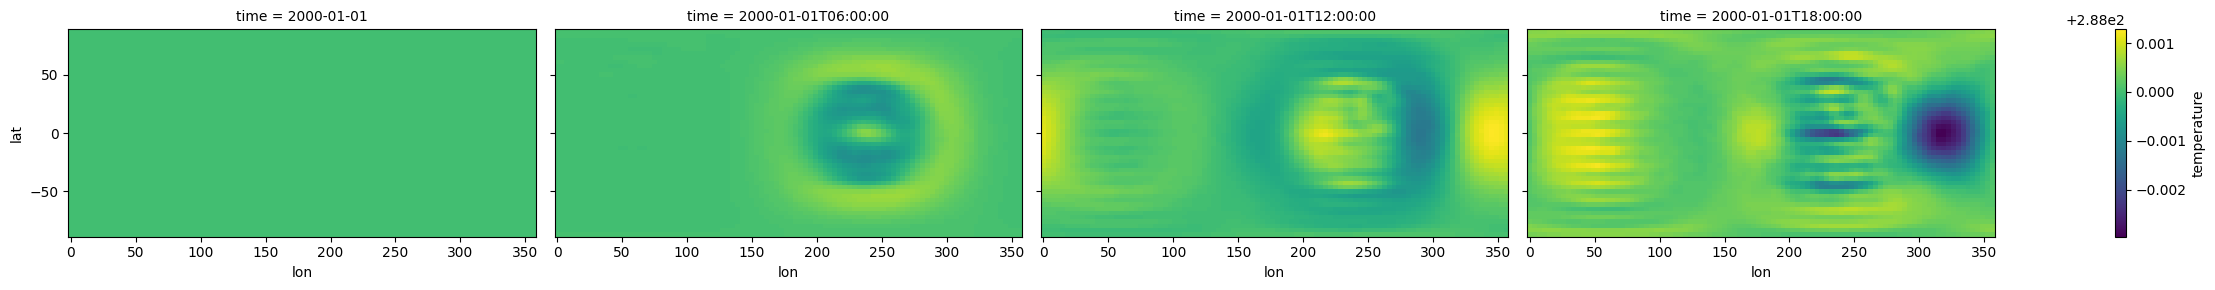

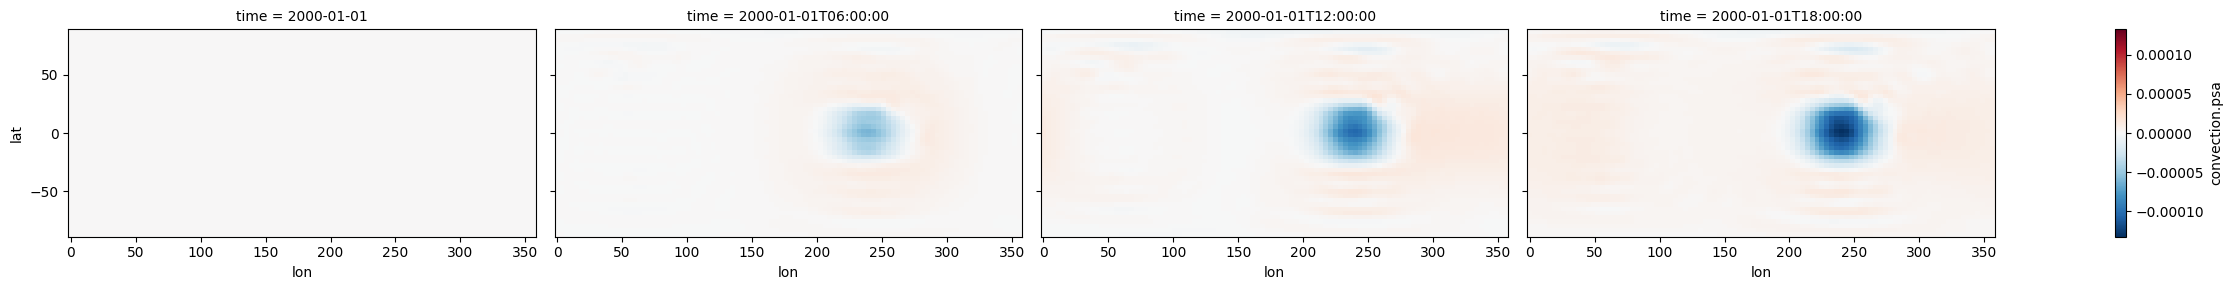

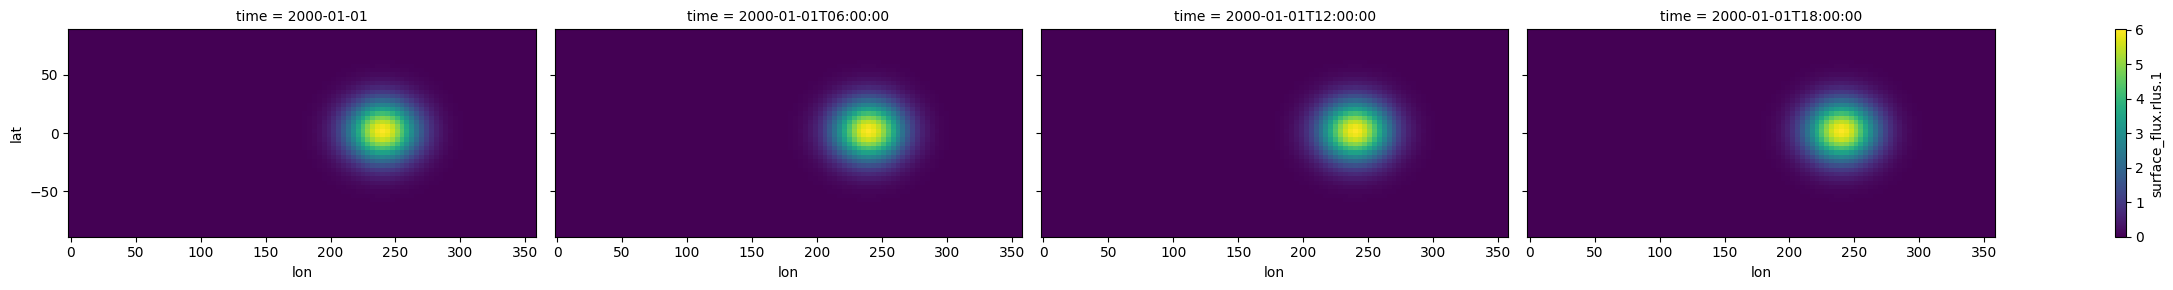

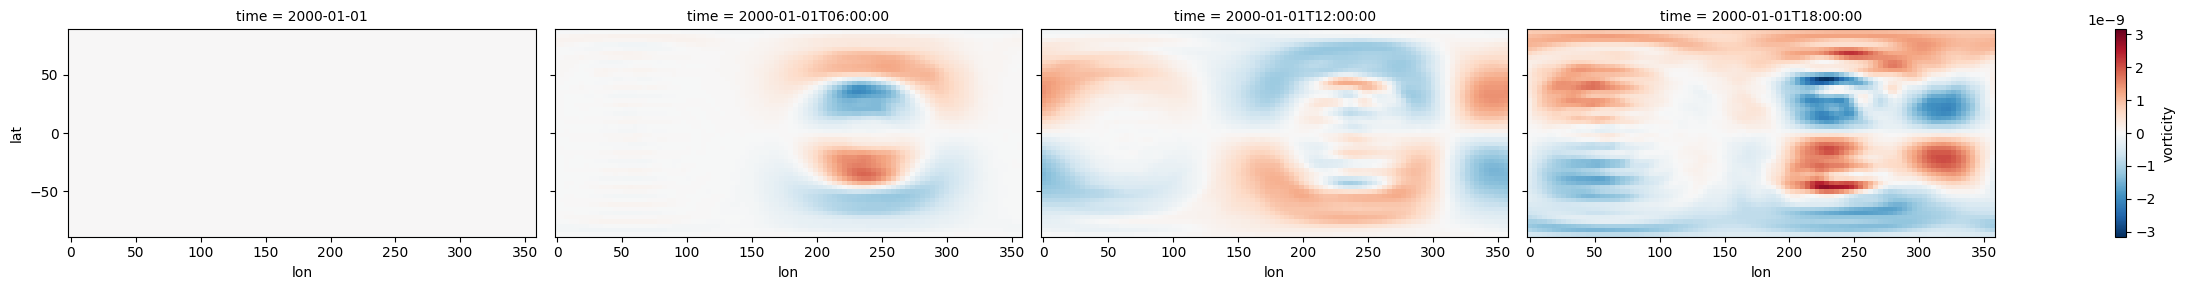

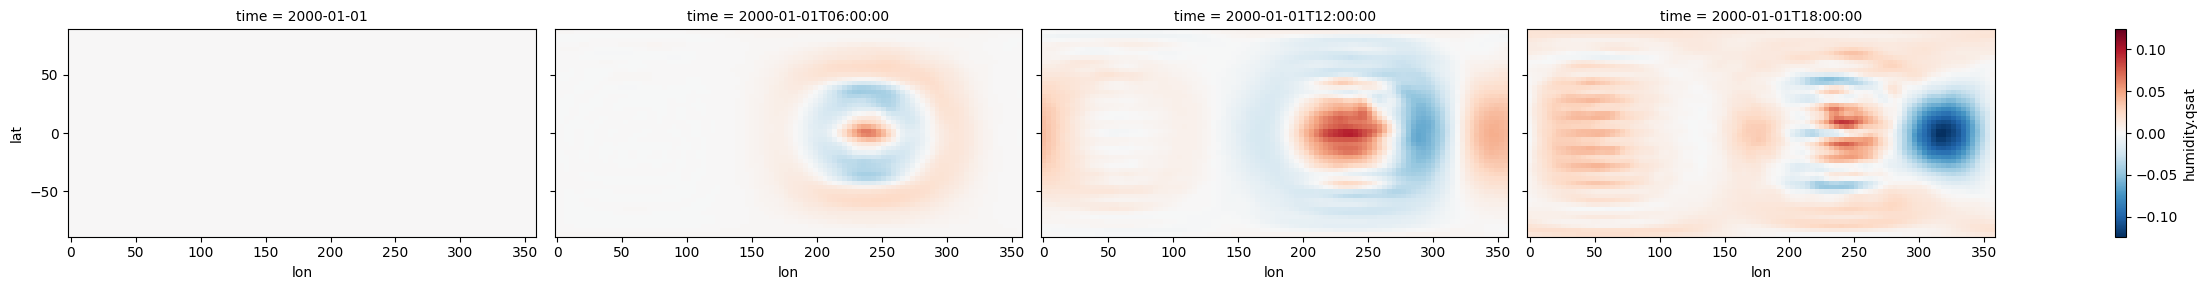

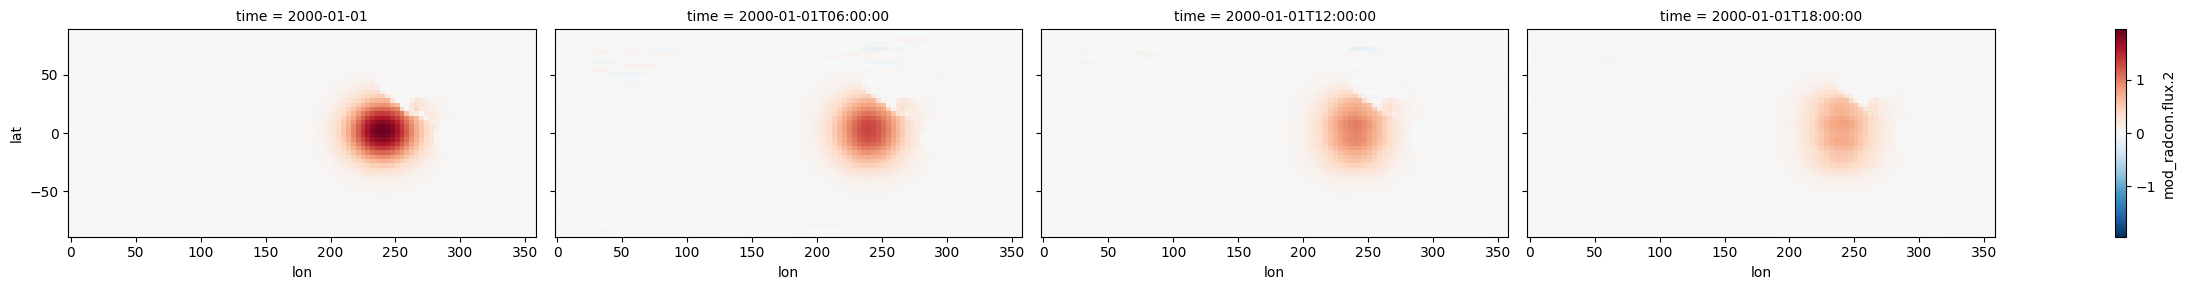

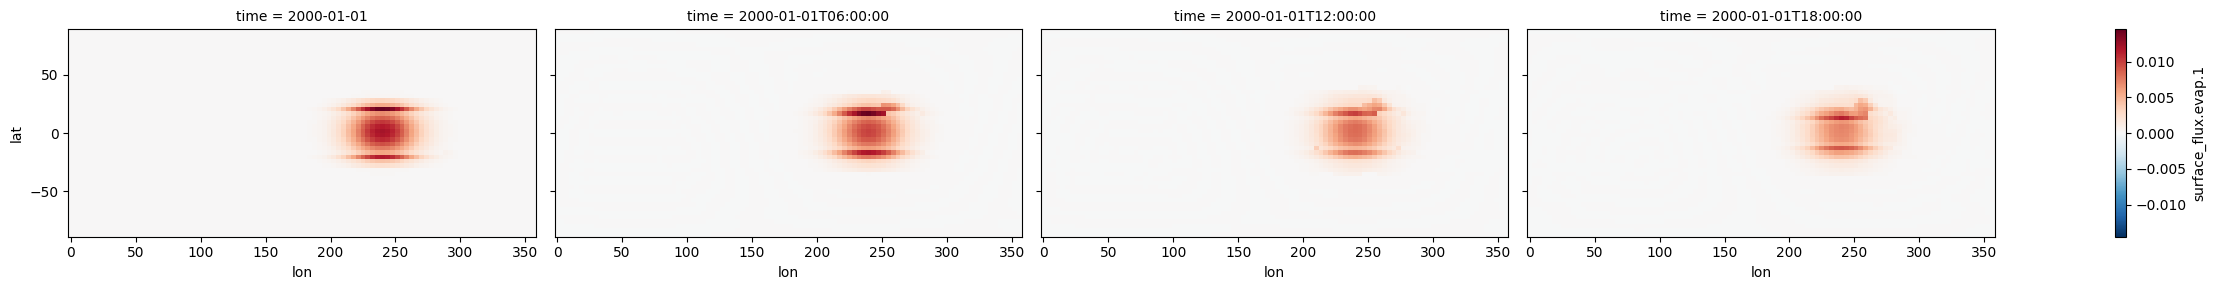

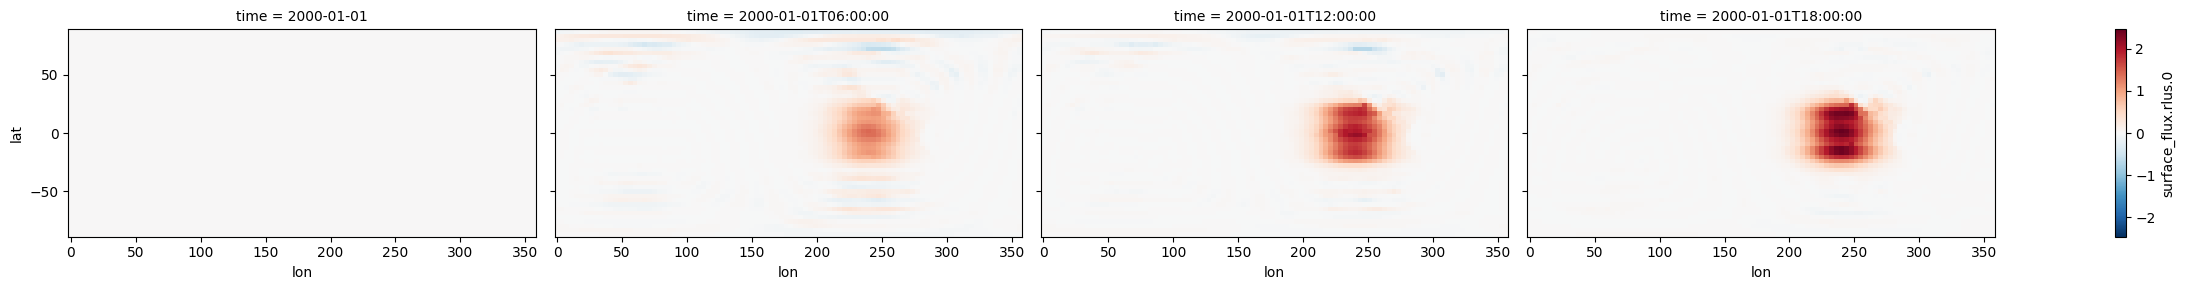

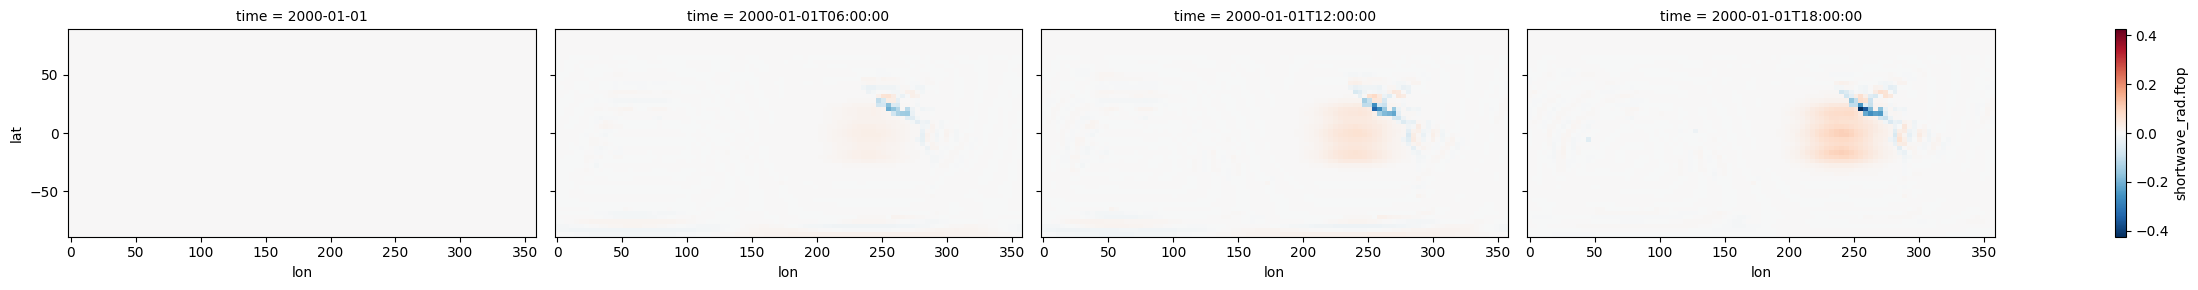

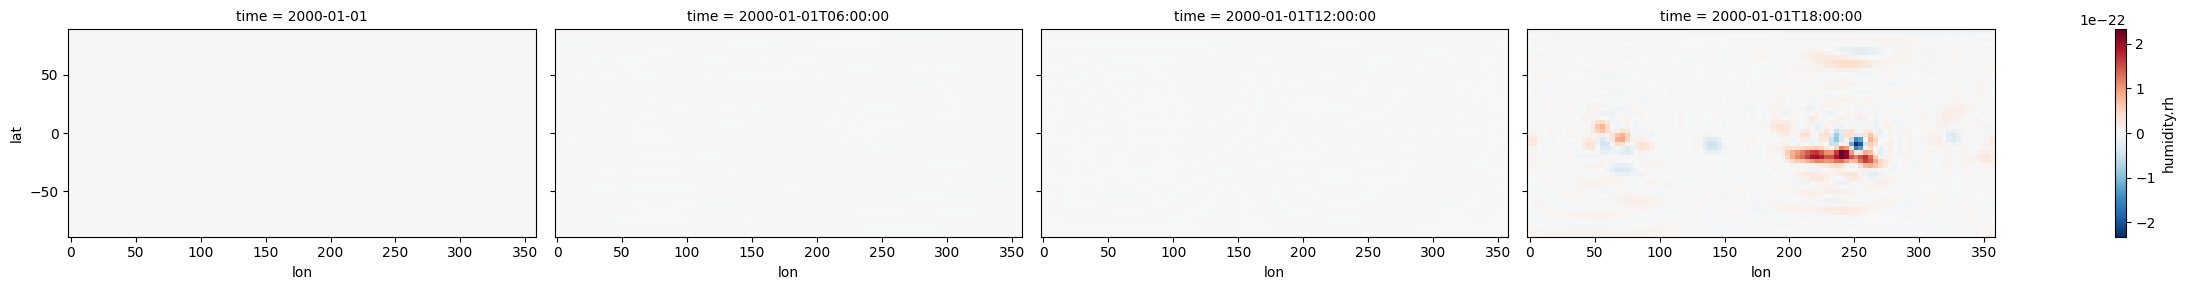

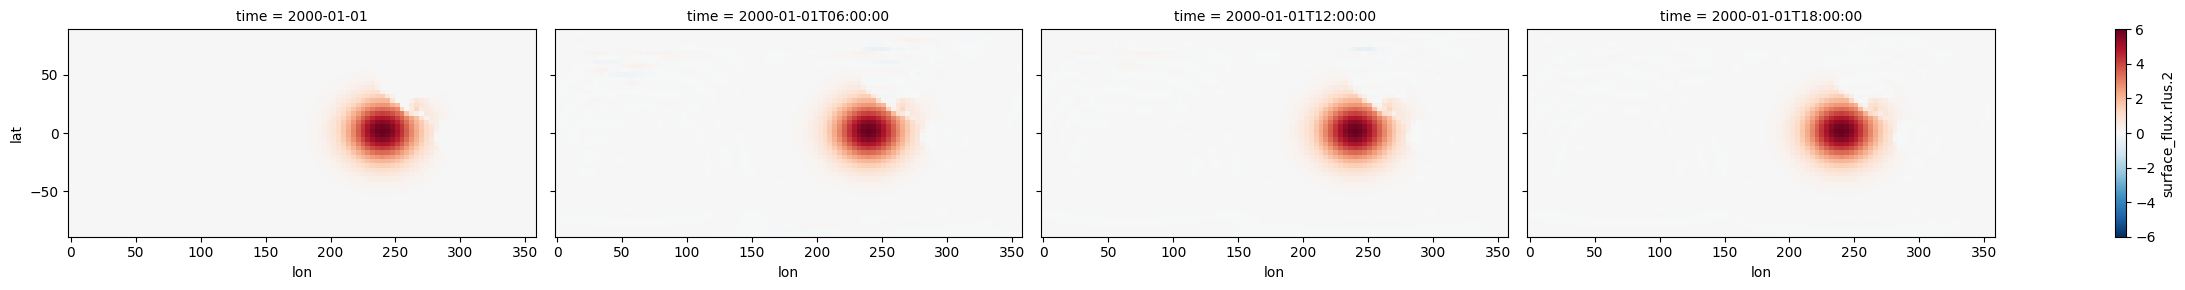

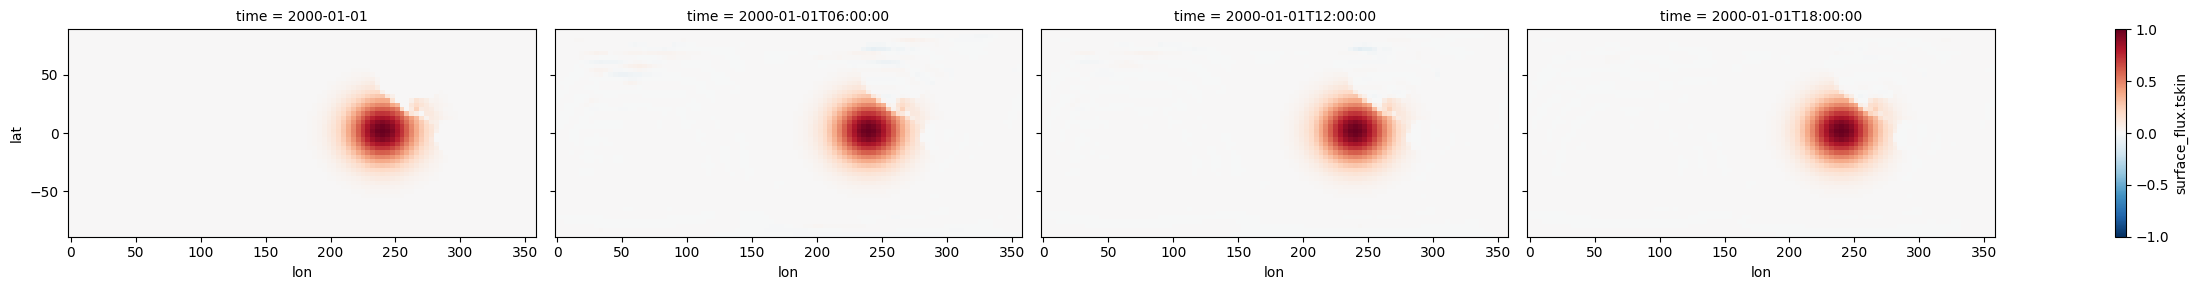

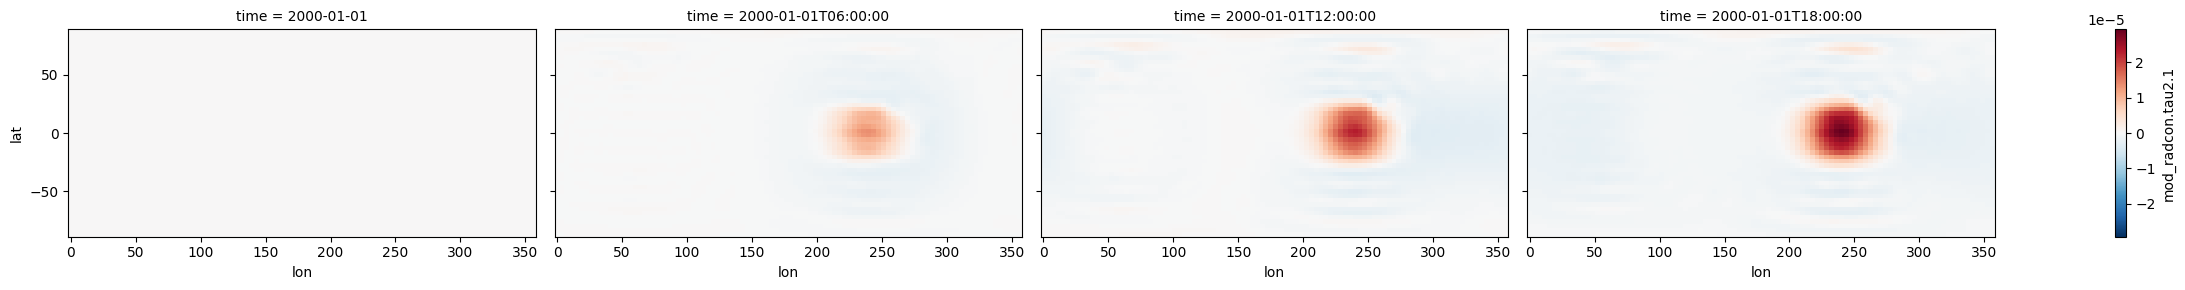

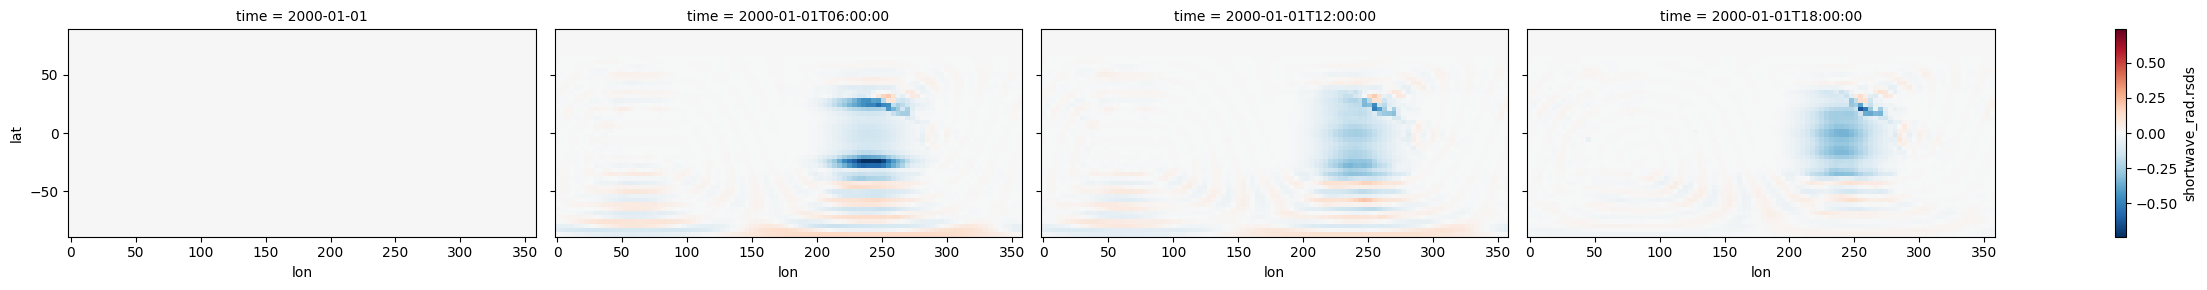

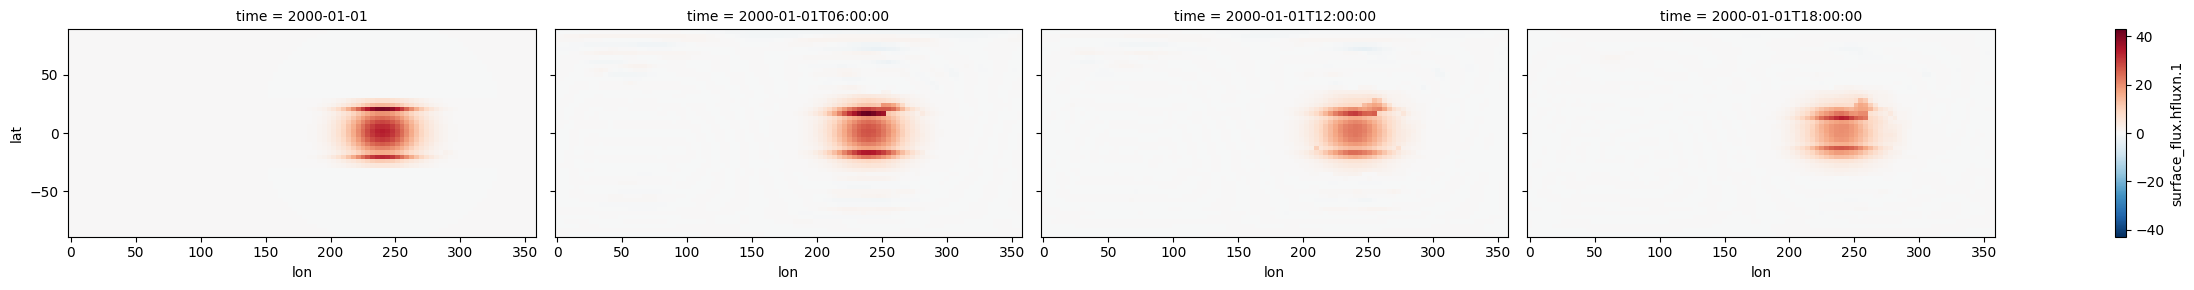

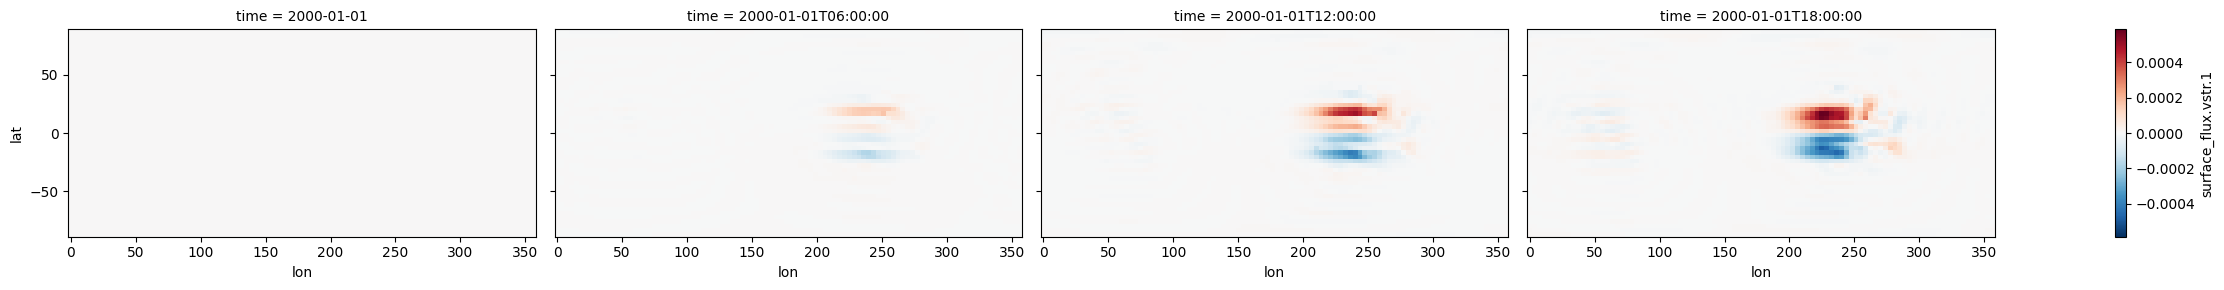

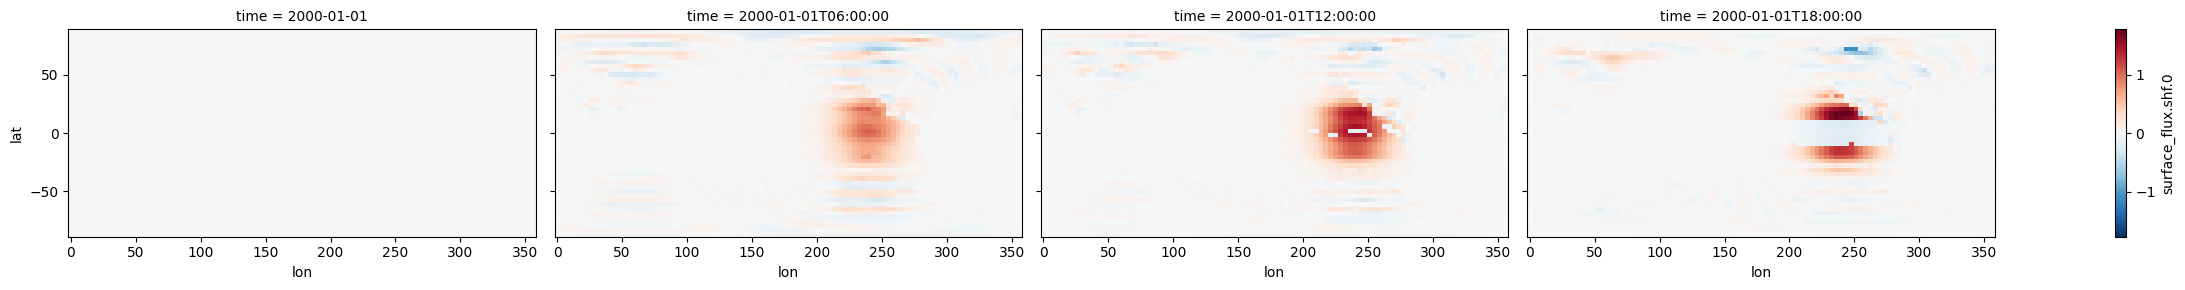

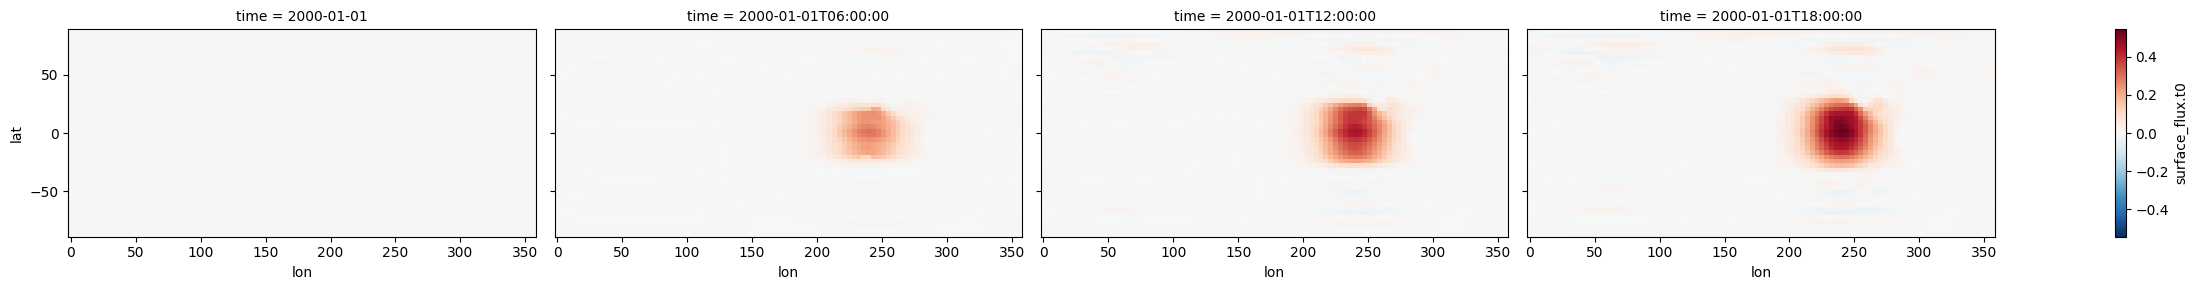

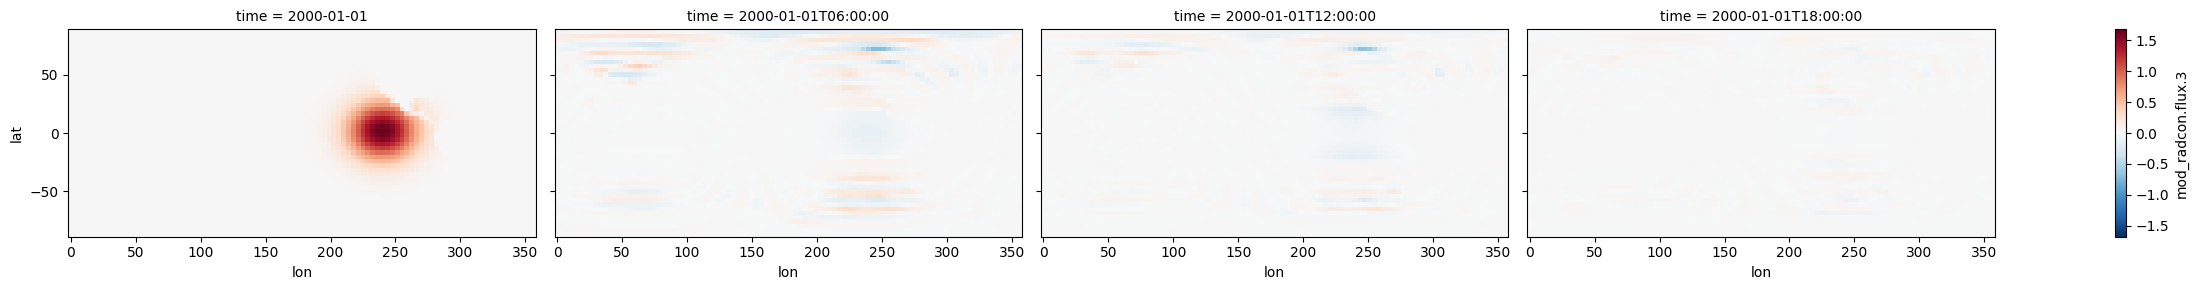

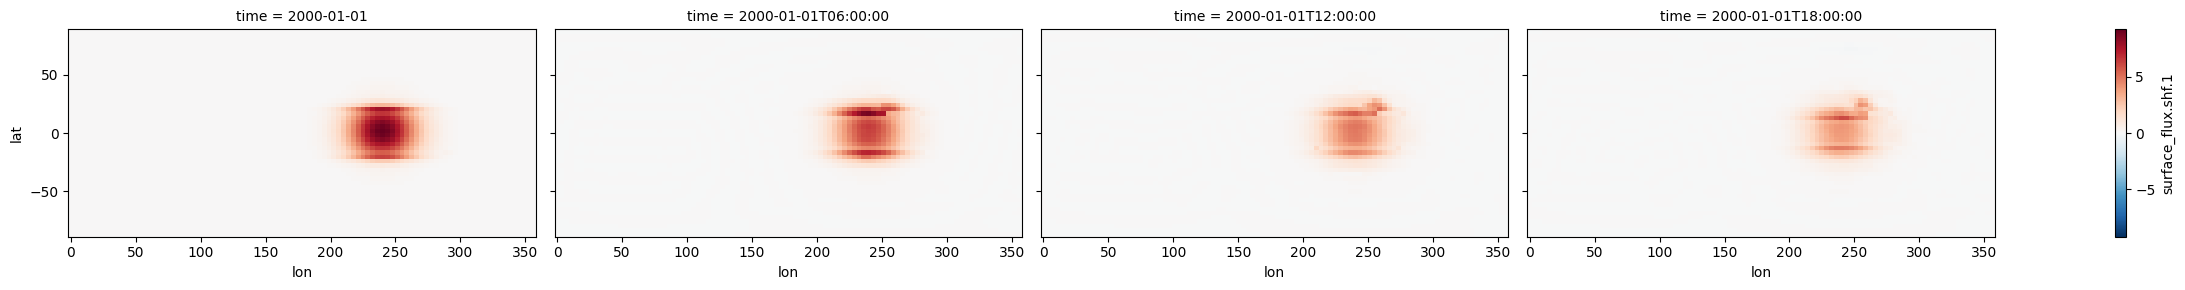

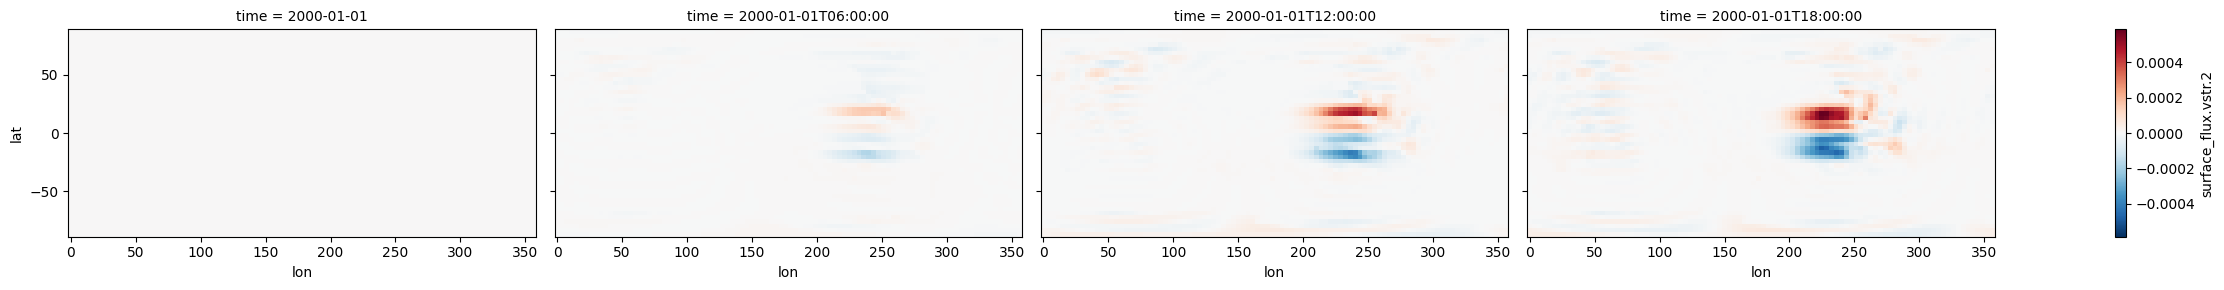

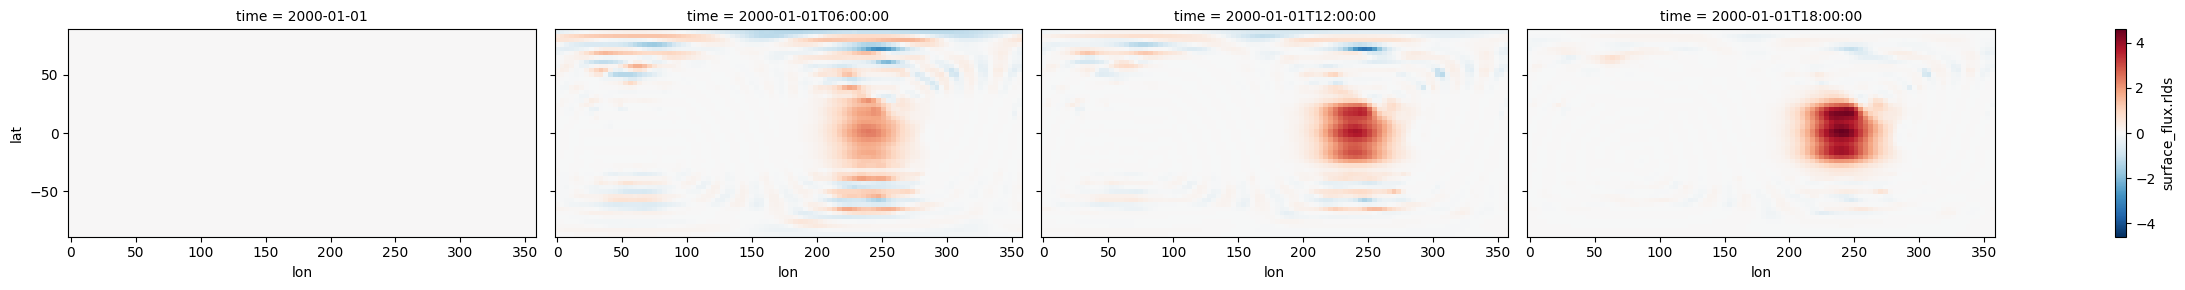

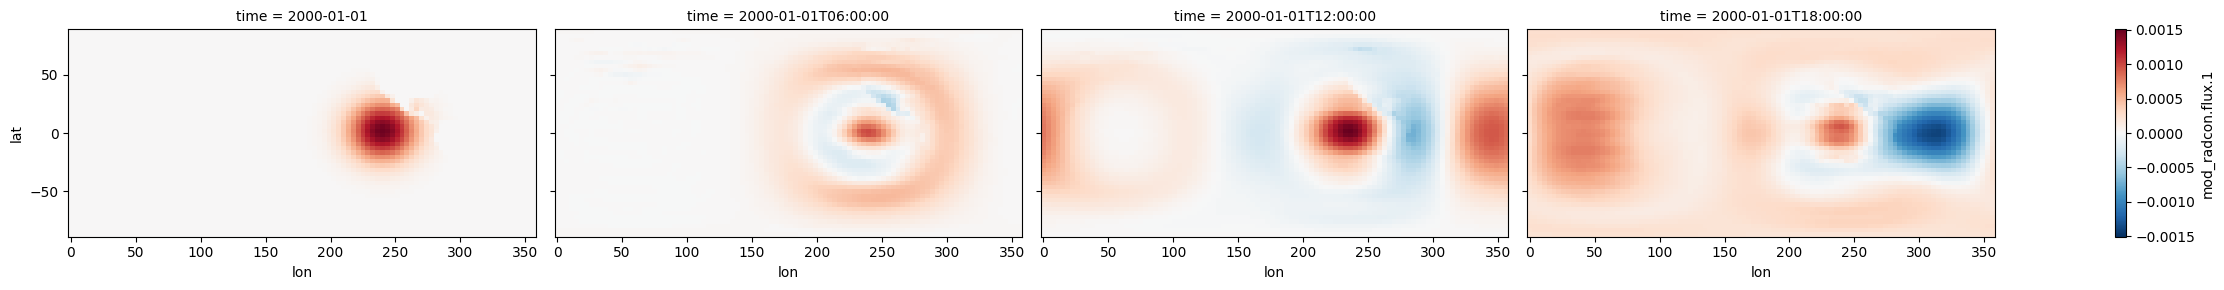

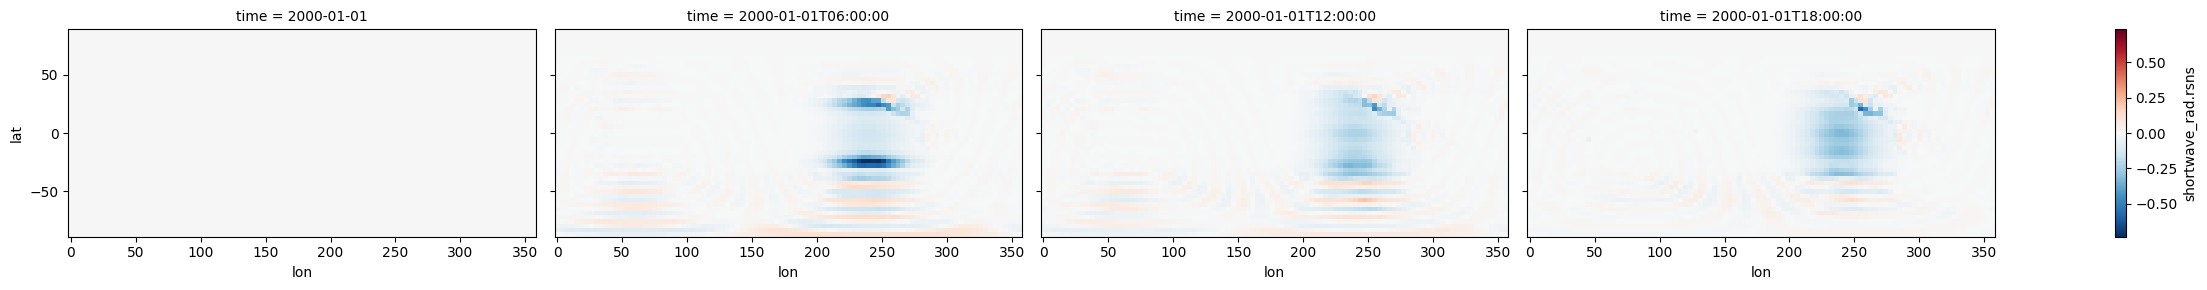

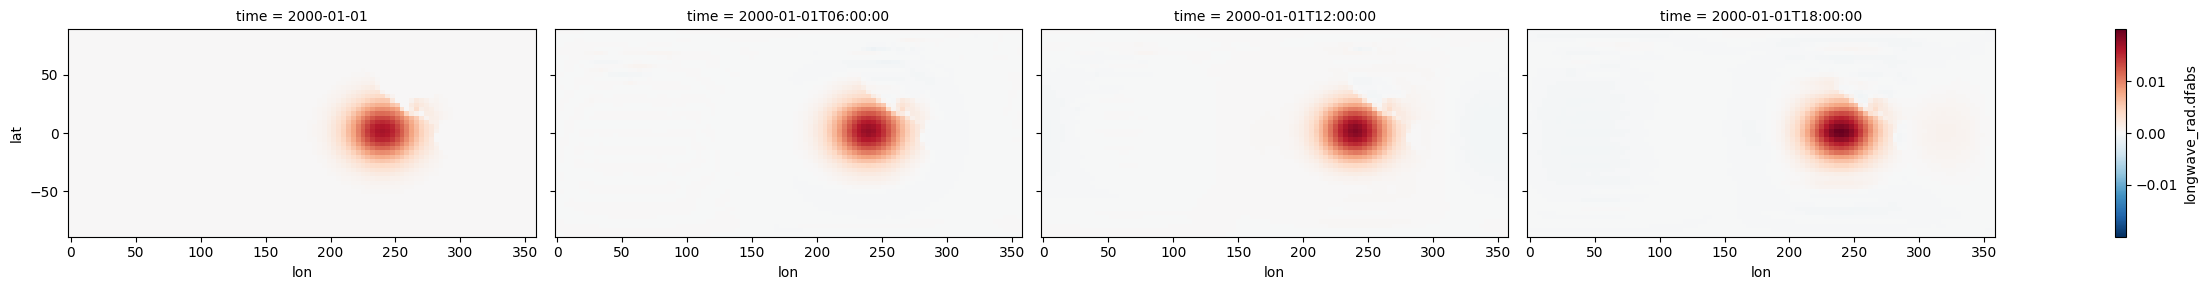

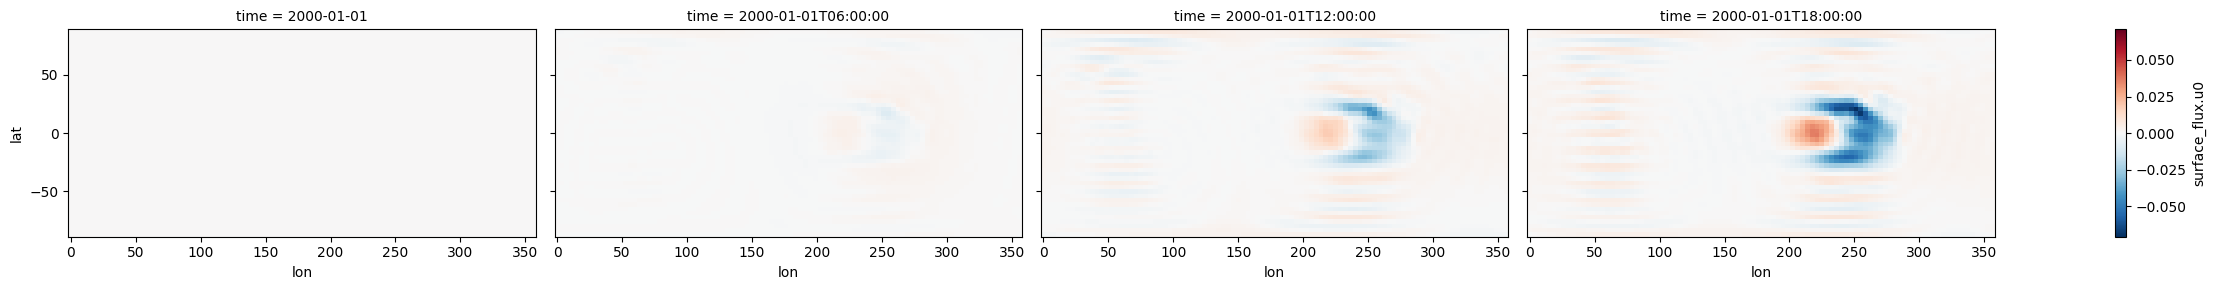

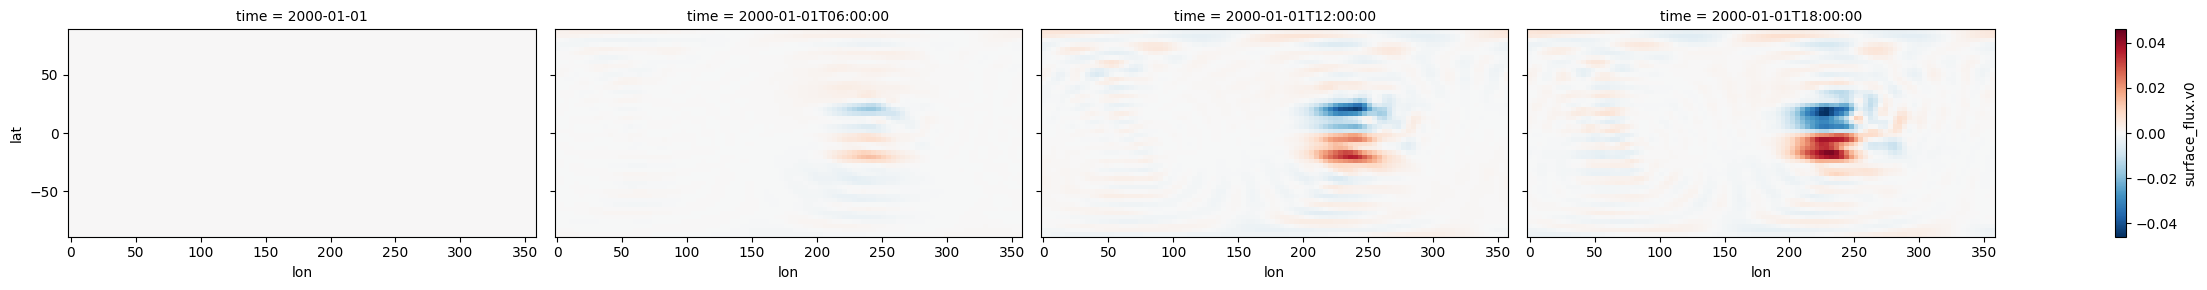

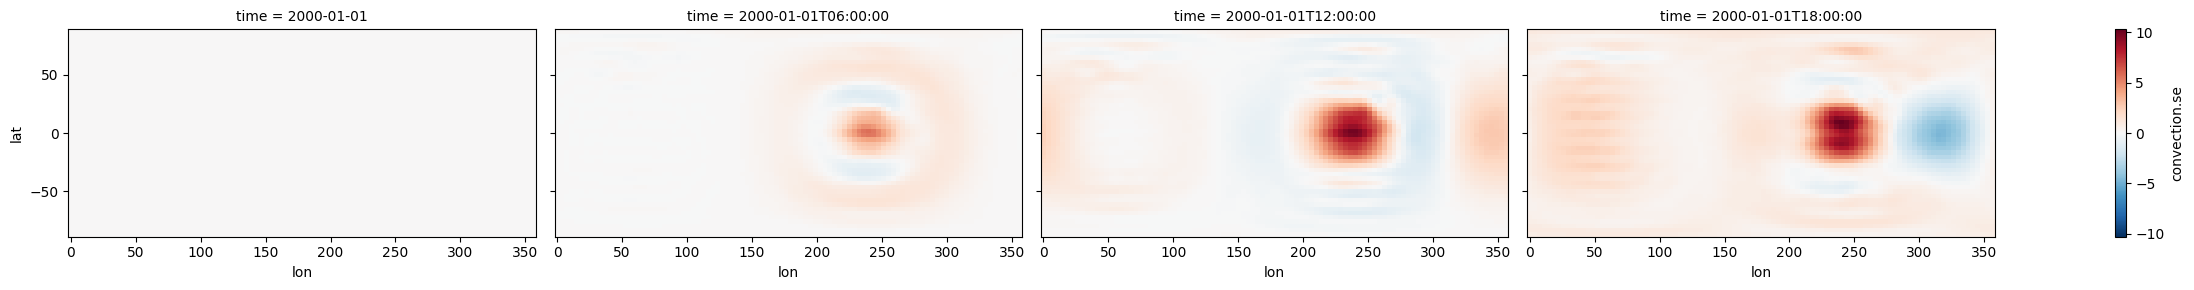

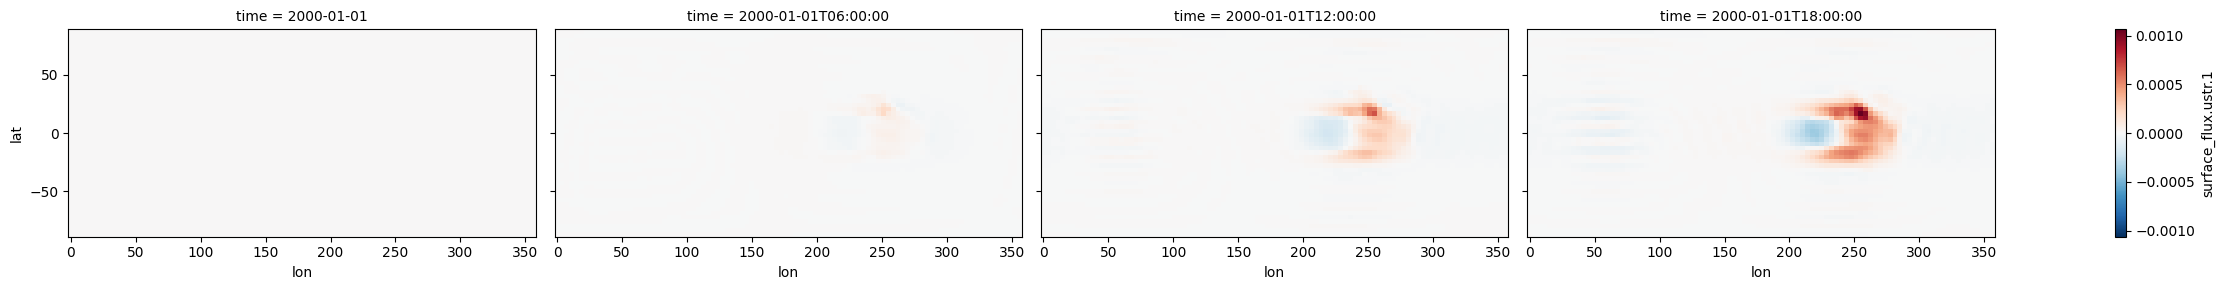

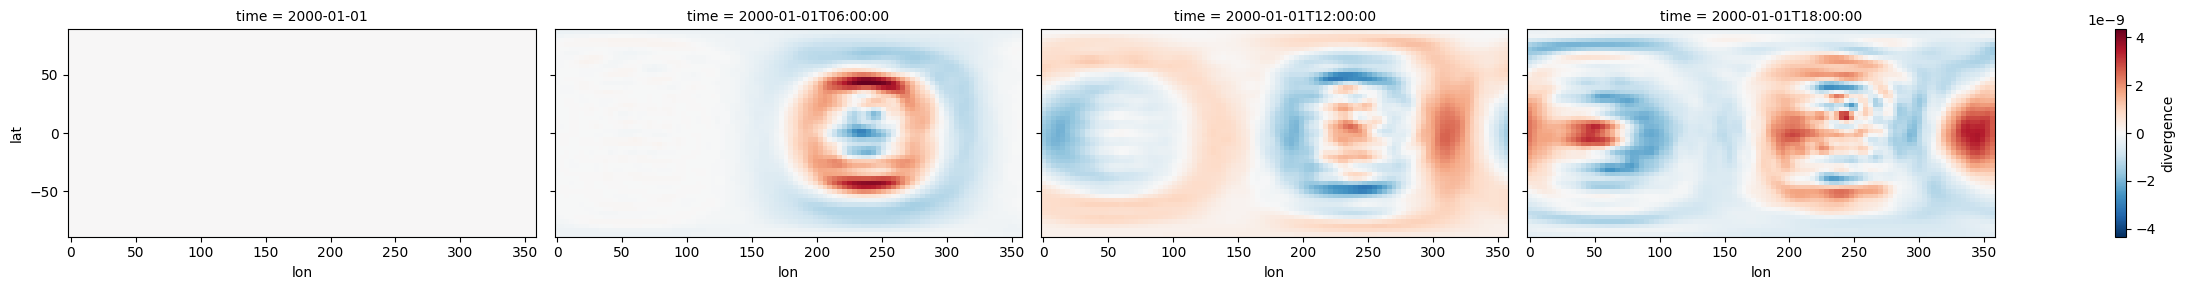

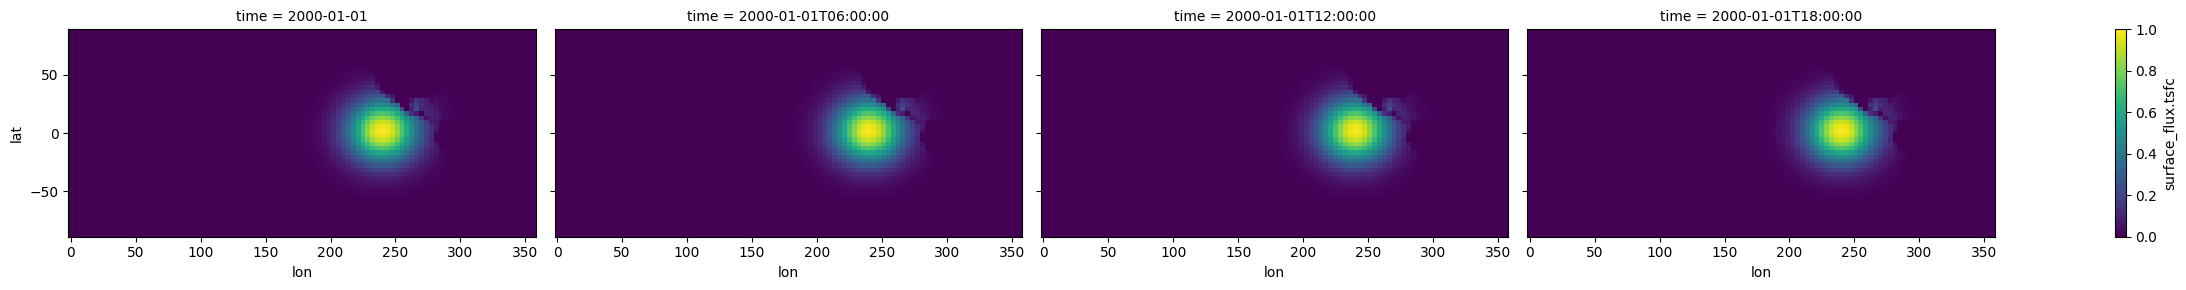

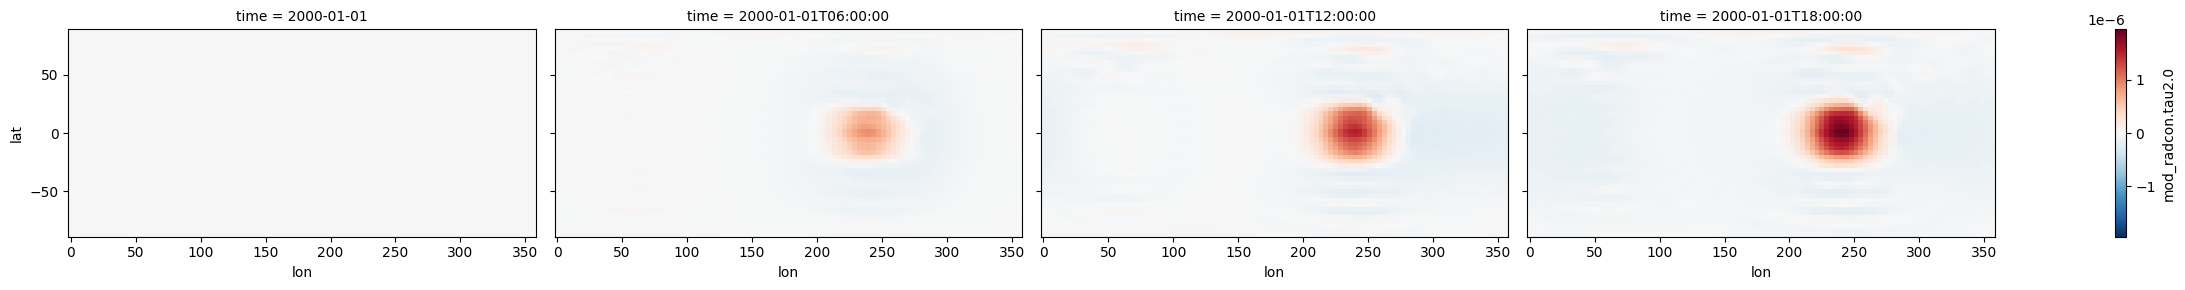

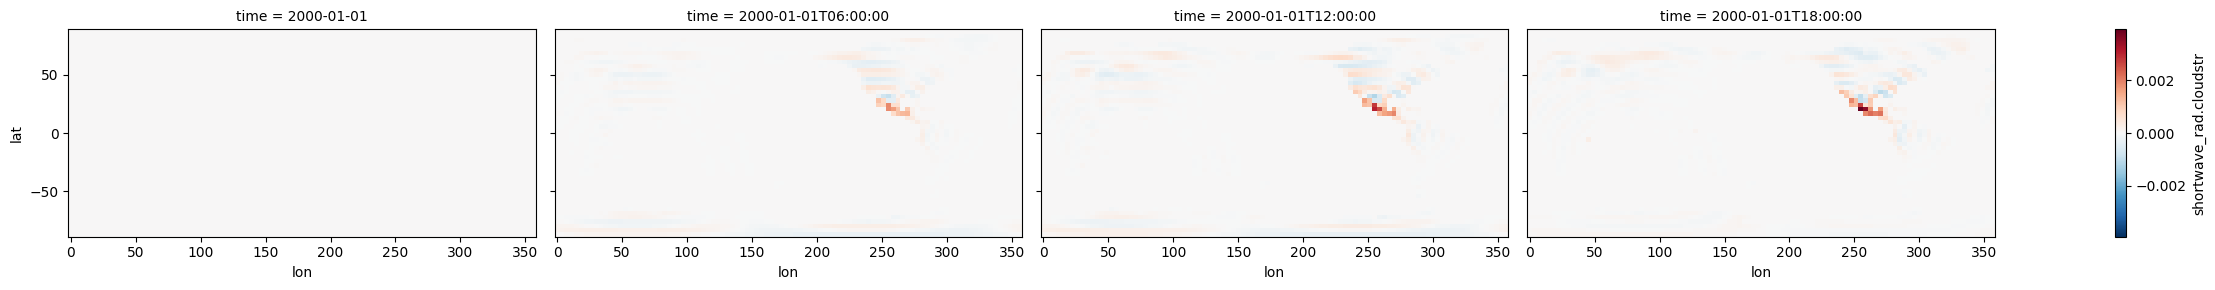

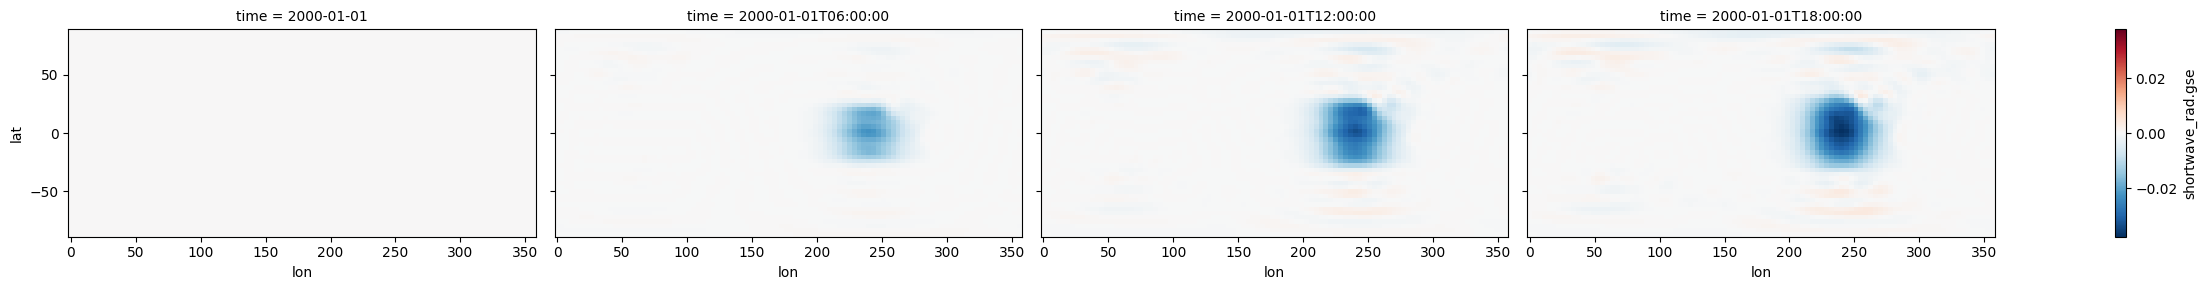

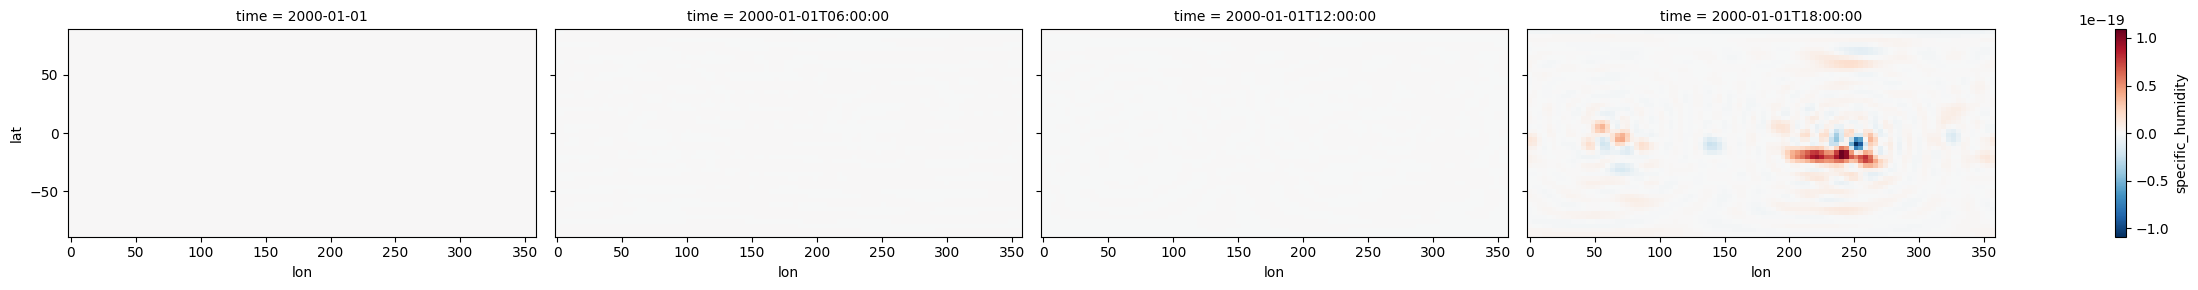

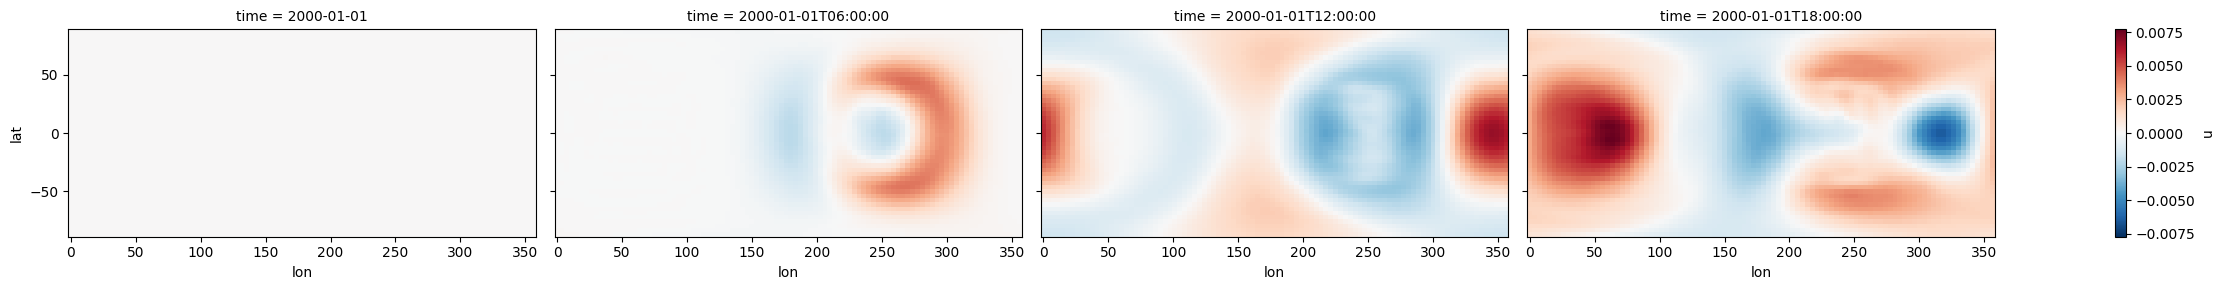

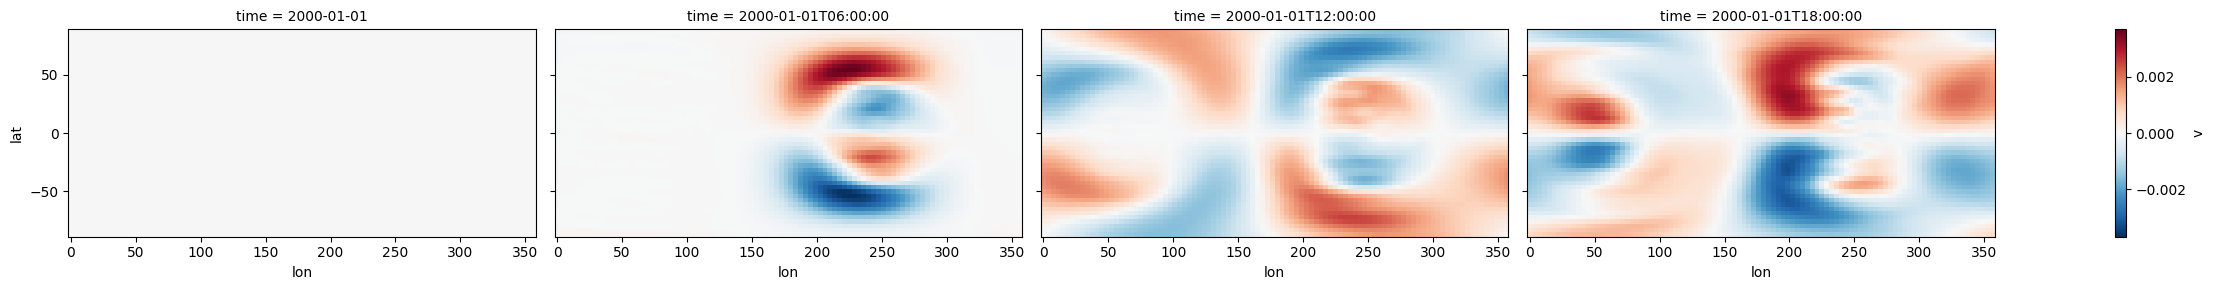

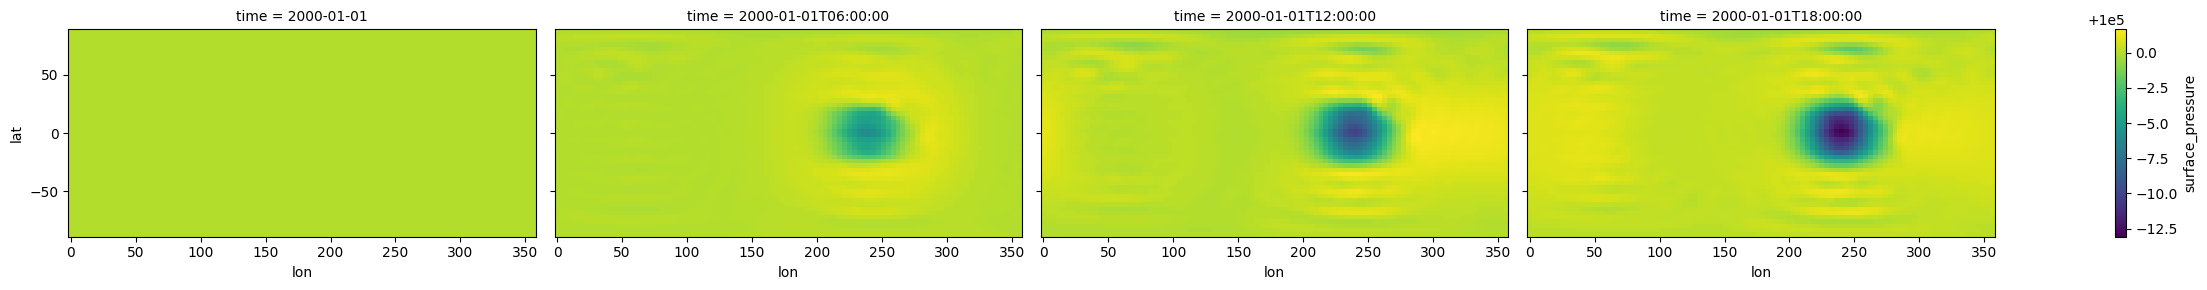

In [ ]:
import numpy as np
plot_ds = grad_ds.isel(level=-1).isel(time=slice(0, 4))
for v in list(plot_ds.data_vars):
    if v in ['mod_radcon.ablco2', 'convection.iptop', 'date.model_year', 'date.model_step', 'date.tyear', 'shortwave_rad.icltop', 'shortwave_rad.compute_shortwave']:
        continue
    data = plot_ds[v]
    if np.nanmax(data) == np.nanmin(data):
        print(f"gradient of {v} is {np.nanmax(data)}")
        continue
    if set(['lon', 'lat', 'time']).issubset(set(list(plot_ds[v].coords))):
        data.plot(x='lon', y='lat', size=3, aspect=2, col='time', col_wrap=4)